**Unsupervised Learning - Anomaly Detection on the Hypothyroidism Dataset**

### Libraries

In [1]:
!pip install gower
!pip install kneed
!pip install plotly

In [4]:
# Basic libraries
import pandas as pd
import numpy as np
import os
from collections import Counter

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

# Scikit Learn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import OneClassSVM

from sklearn import metrics
from sklearn.metrics import DistanceMetric

from sklearn.linear_model import LogisticRegression

# Gower distance, KneeLocator and Kelbow
import gower
from kneed import KneeLocator
from yellowbrick.cluster import KElbowVisualizer # not used

# Deal with warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Google drive mount for colab
from google.colab import drive
drive.mount('/content/drive')

path = "/path/to/your/folder"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Loading and Preprocessing**

### Data loading and first observations

In [5]:
# Load the csv file and drop useless columns

df = pd.read_csv(path+"Unsupervised Learning 23-24 - Project Dataset.csv", sep=";")
df = df.drop(columns = ["Row","Unnamed: 22","Unnamed: 23"])

[N,M] = np.shape(df)

color = "royalblue" #"mediumturquoise" #"cadetblue"
palette = [ "tomato", "royalblue"]

In [6]:
# Check for Na

df.isnull().any()

Dim_0       False
Dim_1=0     False
Dim_2=0     False
Dim_3=0     False
Dim_4=0     False
Dim_5=0     False
Dim_6=0     False
Dim_7=0     False
Dim_8=0     False
Dim_9=0     False
Dim_10=0    False
Dim_11=0    False
Dim_12=0    False
Dim_13=0    False
Dim_14=0    False
Dim_15=0    False
Dim_16      False
Dim_17      False
Dim_18      False
Dim_19      False
Dim_20      False
dtype: bool

There isn't any **_Na_** value in the dataset.

In [7]:
# Check for duplicates

print(f"N° of duplicates: {df.duplicated().sum()}")

N° of duplicates: 71


There are **71** duplicates in the dataset. after observing them with _df[df.duplicated()].value_counts()_, we see that most of them occur in just two copies, only a few as three copies, and only two observations are repeated four and five times. Given that our dataset doesn't have any kind of id feature, we decide to keep the duplicates in the dataset as they are probaby just equal measures rather than errors.

In [ ]:
# Check dtypes

df.dtypes

We can convert the features into the proper data type.

In [ ]:
# Filter continuous and binary variables
object_columns = df.select_dtypes(include=['object'])
int_columns = df.select_dtypes(include=['int64'])

# Convert them into proper type
object_columns = object_columns.apply(lambda x: x.str.replace(',', '.')).astype(float)
int_columns = int_columns.astype(bool)

# Concatenate the fixed df
df = pd.concat([object_columns, int_columns], axis=1)

In [8]:
# Let's observe some statistics about the continous features

df.describe()

Dim_1=0      Dim_2=0      Dim_3=0      Dim_4=0      Dim_5=0  \
count  7200.000000  7200.000000  7200.000000  7200.000000  7200.000000   
mean      0.695694     0.869444     0.984583     0.987222     0.961667   
std       0.460145     0.336937     0.123212     0.112322     0.192013   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     1.000000     1.000000     1.000000     1.000000   
50%       1.000000     1.000000     1.000000     1.000000     1.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

           Dim_6=0      Dim_7=0      Dim_8=0      Dim_9=0     Dim_10=0  \
count  7200.000000  7200.000000  7200.000000  7200.000000  7200.000000   
mean      0.989167     0.985972     0.983194     0.934444     0.931250   
std       0.103525     0.117613     0.128551     0.247521     0.253046   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       1.000000     1.000000     1.000000     1.000000     1.000000   
50%       1.000000     1.000000     1.000000     1.000000     1.000000   
75%       1.000000     1.000000     1.000000     1.000000     1.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

          Dim_11=0     Dim_12=0     Dim_13=0     Dim_14=0     Dim_15=0  
count  7200.000000  7200.000000  7200.000000  7200.000000  7200.000000  
mean      0.987361     0.991806     0.974444     0.999861     0.951111  
std       0.111718     0.090158     0.157816     0.011785     0.215651  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       1.000000     1.000000     1.000000     1.000000     1.000000  
50%       1.000000     1.000000     1.000000     1.000000     1.000000  
75%       1.000000     1.000000     1.000000     1.000000     1.000000  
max       1.000000     1.000000     1.000000     1.000000     1.000000

All of them are already normalized between 0 and 1. However, most of them are very right skewed. We can visualize the distributions both in the _pairplot_ or with a manually defined plotting function which includes also the boxplots.

In [ ]:
# Pairplot

plt.figure(figsize=(7,6))
sns.pairplot(object_columns)
plt.show()

In [ ]:
# Manually defined plotting function

def BoxDistPlot(data, column, figure_number, color=color):

    fig, axes = plt.subplots(ncols=2, figsize=(7, 3), dpi=120)

    # Box plot
    sns.boxplot(x=data[column], ax=axes[0], color=color)
    axes[0].set(xlabel='', ylabel='')

    # Distribution plot
    sns.histplot(data[column], kde=True, ax=axes[1], color=color)
    axes[1].set(xlabel='', ylabel='')

    plt.suptitle(column)
    # plt.savefig(f"{figure_number}.png")
    plt.show()


# Iterate through numerical columns in the DataFrame and plot
figure_number = 1
for numerical_column in object_columns:
    BoxDistPlot(df, numerical_column, figure_number)
    figure_number += 1



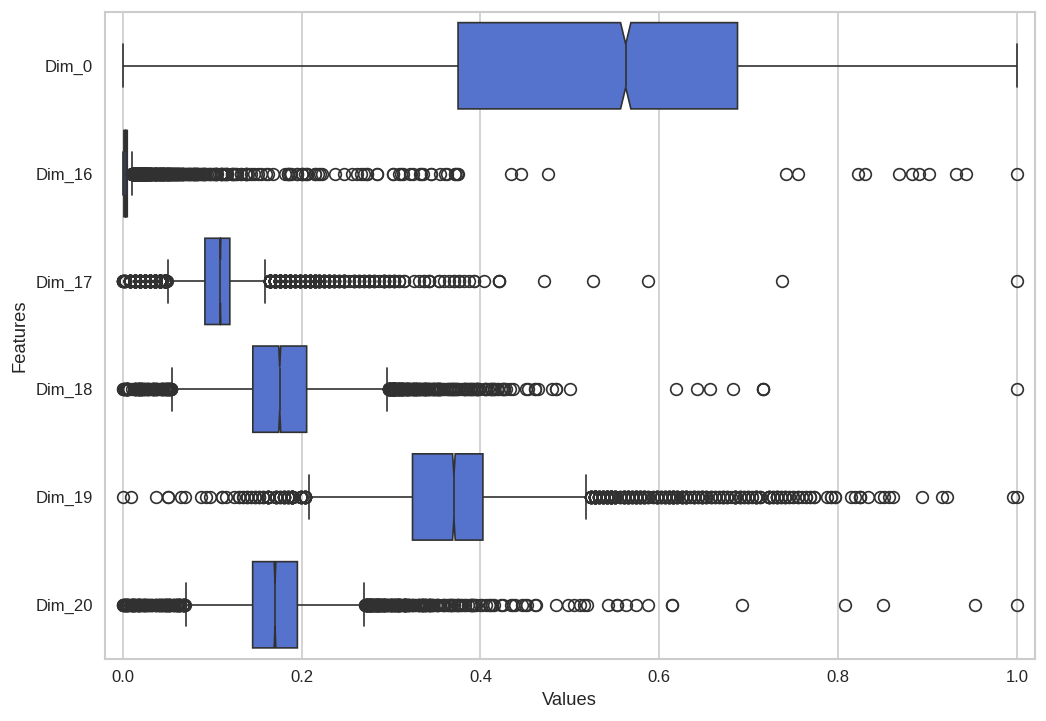

In [ ]:
# All Boxplots

plt.figure(figsize=(10,7), dpi=120)
sns.boxplot(data=object_columns, orient='h', color = color, notch=True, showcaps=True,)
plt.xlim(-0.02, 1.02)
plt.xlabel('Values')
plt.ylabel('Features')
plt.savefig("boxplots.png")
plt.show()

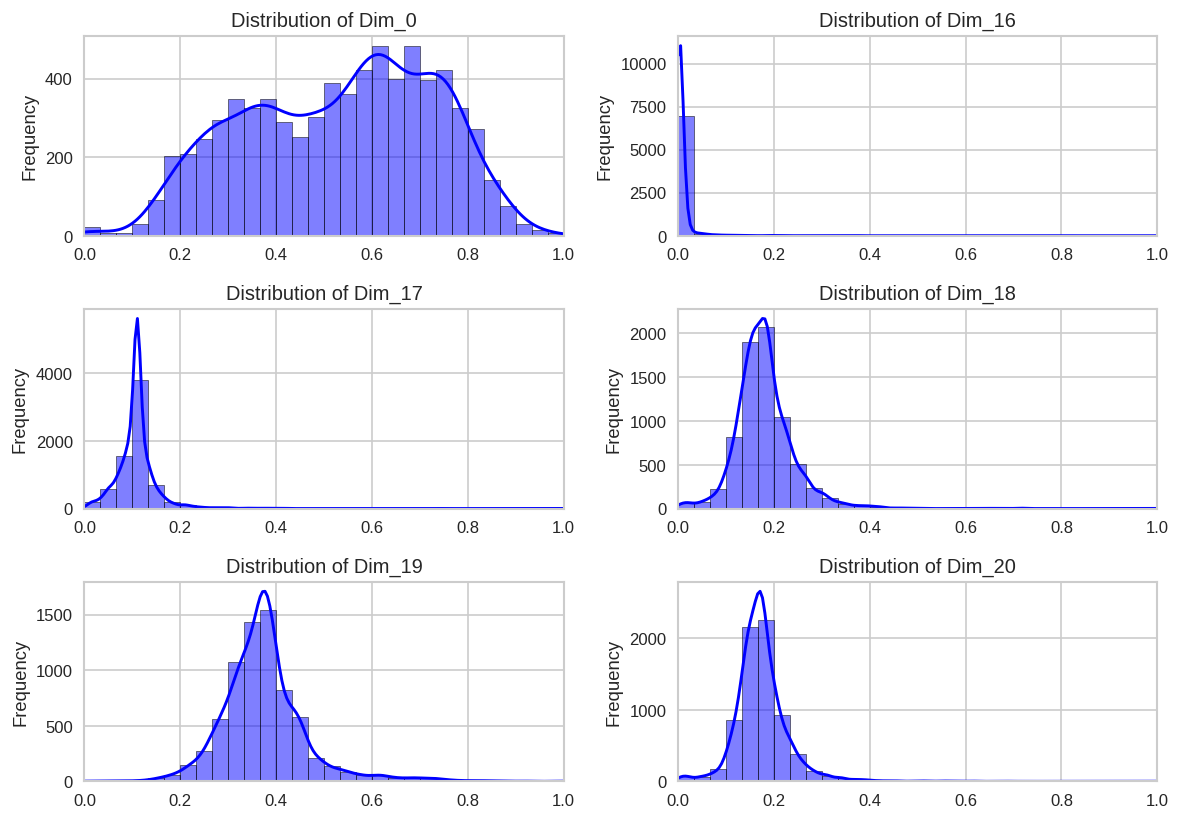

In [ ]:
# All Hist

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 7), dpi=120)
axes = axes.flatten()
for i, column in enumerate(object_columns.columns):
  sns.histplot(df[column], kde=True, ax=axes[i], color='blue', bins=30)
  axes[i].set_xlim(0, 1)
  axes[i].set(xlabel='', ylabel='Frequency')
  axes[i].set_title(f'Distribution of {column}')
plt.tight_layout()
plt.savefig("distplots.png")
plt.show()

In [ ]:
# Visualization of the continous features in 40 subsequent random observations

start = np.random.randint(0, 7140)
end = start + 40

plt.figure(figsize=(10, 7), dpi=120)
plt.plot(df["Dim_0"][start:end], color=color, marker="o", linestyle="-", label='Dim_0')
plt.plot(df["Dim_16"][start:end], 'kx--', label='Dim_16')
plt.plot(df["Dim_17"][start:end], 'rs-.', label='Dim_17')
plt.plot(df["Dim_18"][start:end], 'g^:', label='Dim_18')
plt.plot(df["Dim_19"][start:end], 'yD-', label='Dim_19')
plt.plot(df["Dim_20"][start:end], 'mp-', label='Dim_20')
plt.ylim(-0.02, 1.02)
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
# plt.savefig("contfeat.png")
plt.show()

### Distance measure

In [ ]:
# Manually defined distance matrix for mixed data

def distance_matrix(df, num_distance='euclidean', cat_distance='hamming'):

    [N,M] = np.shape(df)
    proximity_matrix = np.zeros((N, N))

    for col in df.select_dtypes(include=['float']).columns:
      s1 = DistanceMetric.get_metric(num_distance).pairwise(np.array(df[col]).reshape(-1, 1))
      proximity_matrix += s1

    for col in df.select_dtypes(include=['bool']).columns:
      s2 = DistanceMetric.get_metric(cat_distance).pairwise(np.array(df[col]).reshape(-1, 1))
      proximity_matrix += s2

    proximity_matrix /= M

    return np.round(proximity_matrix,4)


In [ ]:
# Compute the gower distance matrix if not found

gower_matrix_path = path + "gower_distance_matrix.npy"

if not os.path.exists(gower_matrix_path):
  gower_distance_matrix = gower.gower_matrix(df)
  np.save(gower_matrix_path, gower_distance_matrix)
else:
  gower_distance_matrix = np.load(gower_matrix_path)

In [ ]:
# Round to 4 decimals

gower_distance_matrix = gower_distance_matrix.round(4)
print(gower_distance_matrix)

[[0.     0.1395 0.1279 ... 0.1617 0.1705 0.1532]
 [0.1395 0.     0.0191 ... 0.0844 0.0704 0.0903]
 [0.1279 0.0191 0.     ... 0.07   0.0666 0.0733]
 ...
 [0.1617 0.0844 0.07   ... 0.     0.1107 0.02  ]
 [0.1705 0.0704 0.0666 ... 0.1107 0.     0.116 ]
 [0.1532 0.0903 0.0733 ... 0.02   0.116  0.    ]]


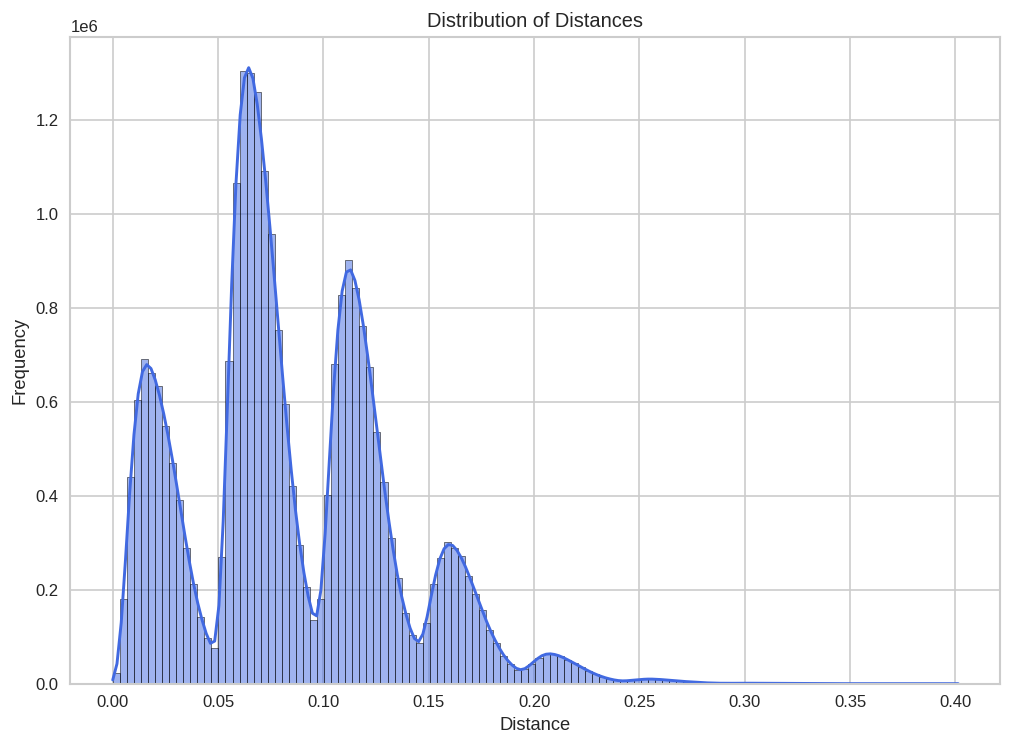

In [ ]:
# Flatten the distance matrix for plotting:
# keeps only the upper triangle and removes diagonal

distance_plot = gower_distance_matrix[np.triu_indices_from(gower_distance_matrix, k=1)]

# Plot the distribution
plt.figure(figsize=(10, 7), dpi=120)
sns.histplot(distance_plot, bins=120, kde=True, color=color)
plt.title('Distribution of Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True)
#plt.savefig("dist.png")
plt.show()

#**Anomaly Detection**

### _Support functions_

In [ ]:
# Plots

def Anomalyplot(sorted_scores, anomaly_thresholds = [], algorithm = '', color = color, t_labels = ['95 percentile threshold', 'KneeLocator threshold']):

  N = len(sorted_scores)
  fig = plt.figure(figsize=(14,6), dpi = 120)
  cols = ['r','b','m']                                         # add if needed

  ax1 = fig.add_subplot(121)
  ax1.hist(sorted_scores, bins = 80, weights = np.ones_like(sorted_scores) / len(sorted_scores), color=color)
  ax1.set_xlabel(f'Anomaly scores {algorithm}', fontsize=14)   #f'Anomaly scores\n({algorithm}, Gower distance)'
  ax1.set_ylabel('Frequency', fontsize=14)
  ax1.grid(True)

  ax2 = fig.add_subplot(122)
  plt.plot(sorted_scores,'-', color = color)
  ax2.set_xlabel('Sorted data points', fontsize=14)
  ax2.set_ylabel(f'Anomaly scores {algorithm}', fontsize=14)
  for i, th in enumerate(anomaly_thresholds):
    x = np.argmax(sorted_scores >= th)
    ax2.axvline(x=x, color=cols[i], linestyle='dotted', label=f'%s = {th.round(4)}' %t_labels[i])
  ax2.grid(True)

  fig.suptitle("Anomaly scores visualizations", fontsize=16)
  plt.legend(fontsize=14)
  plt.savefig("Anomalyplot.png")
  plt.show()


def AnomalyScatterplots(df, anomaly_idxs, feats1=[0,1], feats2=[2,4], palette=palette):

  [N,M] = np.shape(df)
  labels2use = np.ones(N)
  labels2use[list(anomaly_idxs)] = -1
  df_labels = df.copy()
  df_labels['labels'] = np.where(labels2use == 1, 'Normal', 'Anomaly') # To avoid legend glitch

  fig = plt.figure(figsize=(14, 14), dpi=120)

  ax1 = fig.add_subplot(221)
  sns.scatterplot(ax=ax1, x=df_labels.iloc[:, feats1[0]], y=df_labels.iloc[:, feats1[1]], hue=df_labels['labels'], palette=palette)
  ax1.set_title(f'Scatter Plot of Feature {feats1[0]} and Feature {feats1[1]}', fontsize=14)
  ax1.set_xlabel(df.columns[feats1[0]], fontsize=14)
  ax1.set_ylabel(df.columns[feats1[1]], fontsize=14)
  ax1.legend(fontsize=14, loc='upper right')
  ax1.grid(True)

  ax2 = fig.add_subplot(222)
  sns.scatterplot(ax=ax2, x=df_labels.iloc[:, feats2[0]], y=df_labels.iloc[:, feats2[1]], hue=df_labels['labels'], palette=palette)
  ax2.set_title(f'Scatter Plot of Feature {feats2[0]} and Feature {feats2[1]}', fontsize=14)
  ax2.set_xlabel(df.columns[feats2[0]], fontsize=14)
  ax2.set_ylabel(df.columns[feats2[1]], fontsize=14)
  ax2.legend(fontsize=14, loc='upper right')
  ax2.grid(True)

  ax3 = fig.add_subplot(223)
  tsne = TSNE(n_components = 2, verbose = 0, perplexity = 100, n_iter = 500, random_state=42) # There's a bit of randomness
  tsne_results = tsne.fit_transform(df)
  sns.scatterplot(ax=ax3, x=tsne_results[:, 0], y=tsne_results[:, 1], hue=df_labels['labels'], palette=palette)
  ax3.set_title('2 Components t-SNE Visualization', fontsize=14)
  ax3.set_xlabel('Dimension 1', fontsize=14)
  ax3.set_ylabel('Dimension 2', fontsize=14)
  ax3.legend(fontsize=14, loc='upper right')
  ax3.grid(True)

  ax4 = fig.add_subplot(224)
  pca = PCA(n_components=2, random_state=42)                   # There's a bit of randomness
  pca_result = pca.fit_transform(df)
  exp_var = (pca.explained_variance_ratio_ * 100).round(2)
  sns.scatterplot(ax=ax4, x=pca_result[:, 0], y=pca_result[:, 1], hue=df_labels['labels'], palette=palette)
  ax4.set_title(f'2 Components PCA Visualization (Explained variance: {exp_var[0]}% and {exp_var[1]}%)', fontsize=14)
  ax4.set_xlabel('Principal Component 1', fontsize=14)
  ax4.set_ylabel('Principal Component 2', fontsize=14)
  ax4.legend(fontsize=14, loc='upper right')
  ax4.grid(True)

  fig.suptitle("Anomaly Scatter Plots", weight='bold', fontsize=16)
  plt.tight_layout()
  plt.savefig("AnomalyScatterplots.png")
  plt.show()



def PCA3dscatter(df, anomaly_idxs, palette=palette):

  [N,M] = np.shape(df)
  labels2use = np.ones(N)
  labels2use[list(anomaly_idxs)] = -1
  df_labels = df.copy()
  df_labels['labels'] = np.where(labels2use == 1, 'Normal', 'Anomaly')


  pca = PCA(n_components=3)
  pca_result = pca.fit_transform(df)
  exp_var = (pca.explained_variance_ratio_ * 100).round(2)

  fig = plt.figure(figsize=(14, 10), dpi=120)
  ax = fig.add_subplot(111, projection='3d')

  scatter = ax.scatter(
      pca_result[:, 0], pca_result[:, 1], pca_result[:, 2],
      c = [palette[1] if label == 'Normal' else palette[0] for label in df_labels['labels']],
      label=df_labels['labels']
  )

  ax.set_title(f'3 Components PCA Visualization (Explained variance: {exp_var[0]}%, {exp_var[1]}%, {exp_var[2]}%)', fontsize=16)
  ax.set_xlabel('Principal Component 1', fontsize=14)
  ax.set_ylabel('Principal Component 2', fontsize=14)
  ax.set_zlabel('Principal Component 3', fontsize=14)


  normal_patch = plt.Line2D([0], [0], linestyle="none", marker="o", markersize=10, markerfacecolor = palette[0])
  anomaly_patch = plt.Line2D([0], [0], linestyle="none", marker="o", markersize=10, markerfacecolor = palette[1])
  ax.legend([normal_patch, anomaly_patch], ['Anomaly', 'Normal'], numpoints=1, fontsize=14)
  plt.savefig("PCA3dscatter.png")
  plt.show()


def PCA3dscatterITERATIVE(df, anomaly_idxs, palette=palette):
  '''
  Iterative version using plotly
  '''

  [N,M] = np.shape(df)
  labels2use = np.ones(N)
  labels2use[list(anomaly_idxs)] = -1
  df_labels = df.copy()
  df_labels['labels'] = np.where(labels2use == 1, 'Normal', 'Anomaly')

  pca = PCA(n_components=3)
  pca_result = pca.fit_transform(df)
  exp_var = (pca.explained_variance_ratio_ * 100).round(2)

  pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3'])
  pca_df['labels'] = df_labels['labels']

  fig = px.scatter_3d(
      pca_df, x='PC1', y='PC2', z='PC3',
      color='labels', color_discrete_map={'Normal': palette[1], 'Anomaly': palette[0]},
      title=f'3 Components PCA Visualization (Explained variance: {exp_var[0]}%, {exp_var[1]}%, {exp_var[2]}%)'
  )
  fig.update_layout(scene=dict(
      xaxis_title='Principal Component 1',
      yaxis_title='Principal Component 2',
      zaxis_title='Principal Component 3'
  ))

  fig.show()


# Anomaly detection

def LOF(dist_matrix, num_neigh=int(np.sqrt(N))):

  N = dist_matrix[0].shape[0]

  # Fit Nearest Neighbors model with precomputed distance matrix
  nbrs = NearestNeighbors(n_neighbors=num_neigh, metric='precomputed')
  nbrs.fit(dist_matrix)

  # Find the k-nearest neighbors for each observation and compute distance
  distances, indices = nbrs.kneighbors(dist_matrix)

  # Compute reachability distance between each pair of data samples
  reach_dist_array = np.zeros_like(distances)
  for i in range(N):
      reach_dist_array[i] = np.maximum(distances[i], distances[indices[i, -1]])

  # Calculate local reachability density (LRD)
  lrd = np.zeros(N)
  for i in range(N):
      lrd[i] = 1 / (np.mean(reach_dist_array[i]) + 1e-10)  # adding a small value to avoid division by zero

  # Calculate LOF scores
  lof_scores = np.zeros(N)
  for i in range(N):
      lof_scores[i] = np.mean(lrd[indices[i]]) / lrd[i]

  return lof_scores


### 1. **KNN** - _proximity, distance based_

**KEY ASSUMPTION:**  Normal data objects have close neighbors, while anomalies are data objects most distant from other data objects.

In [ ]:
# Parameters:

n_neighbors = int(np.sqrt(N))                # Number of neighbors to consider, √n usually leads to good results
S = 1                                        # Sensitivity parameter for KneeLocator

# Fit Nearest Neighbors model using precomputed distances

nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric='precomputed')
nbrs.fit(gower_distance_matrix)

# Find the k-nearest neighbors for each observation

distances, indices = nbrs.kneighbors(gower_distance_matrix)

'''
- distances is a (7200, 84) array. Each row contains the gower distance of that data object to the 84 nn
- indices is a (7200, 84) array. Each row contains the indices of the 84 nn of that data object
'''

# Compute anomaly scores (further distance, could also use mean or median distance)

anomaly_scores_KNN = distances[:,-1]
#anomaly_scores_KNN = distances.mean(axis=1)


# Zip the anomaly scores with the idxs = np.arange(N) in order to sort the indices

idxs = np.arange(N).tolist()

combined = list(zip(anomaly_scores_KNN, idxs))
sorted_anomalies = sorted(combined, key=lambda x: x[0])
sorted_scores_KNN, sorted_idxs_KNN = zip(*sorted_anomalies)

#-------------------------------------------------------------------------------

# Identify anomalies USING PERCENTILES

threshold_perc_KNN = np.percentile(sorted_scores_KNN, 95).astype("float64")   # flag top 5% as anomalies

# Identify anomalies USING KNEE LOCATOR

kneedle = KneeLocator(range(N), sorted_scores_KNN, S=S, curve='convex', direction='increasing')
knee_point = kneedle.elbow
threshold_knee_KNN = sorted_scores_KNN[knee_point].astype("float64")


# Saving anomalies, idxs and not anomalies
anomalies_perc_KNN = np.where(sorted_scores_KNN > threshold_perc_KNN)[0]
anomalies_knee_KNN = np.where(sorted_scores_KNN > threshold_knee_KNN)[0]

anomalies_idxs_perc_KNN = sorted_idxs_KNN[-len(anomalies_perc_KNN):]
anomalies_idxs_knee_KNN = sorted_idxs_KNN[-len(anomalies_knee_KNN):]

# Array for majority vote
anomalies_KNN = np.ones(N)
anomalies_KNN[list(anomalies_idxs_perc_KNN)] = -1


print("KNN anomaly scores sample:", np.array(sorted_scores_KNN))
print("N° of top 5% anomalies:", len(anomalies_perc_KNN))
print("N° of KneeLocator anomalies:", len(anomalies_knee_KNN))

KNN anomaly scores sample: [0.0035 0.0035 0.0035 ... 0.1511 0.1544 0.157 ]
N° of top 5% anomalies: 358
N° of KneeLocator anomalies: 12


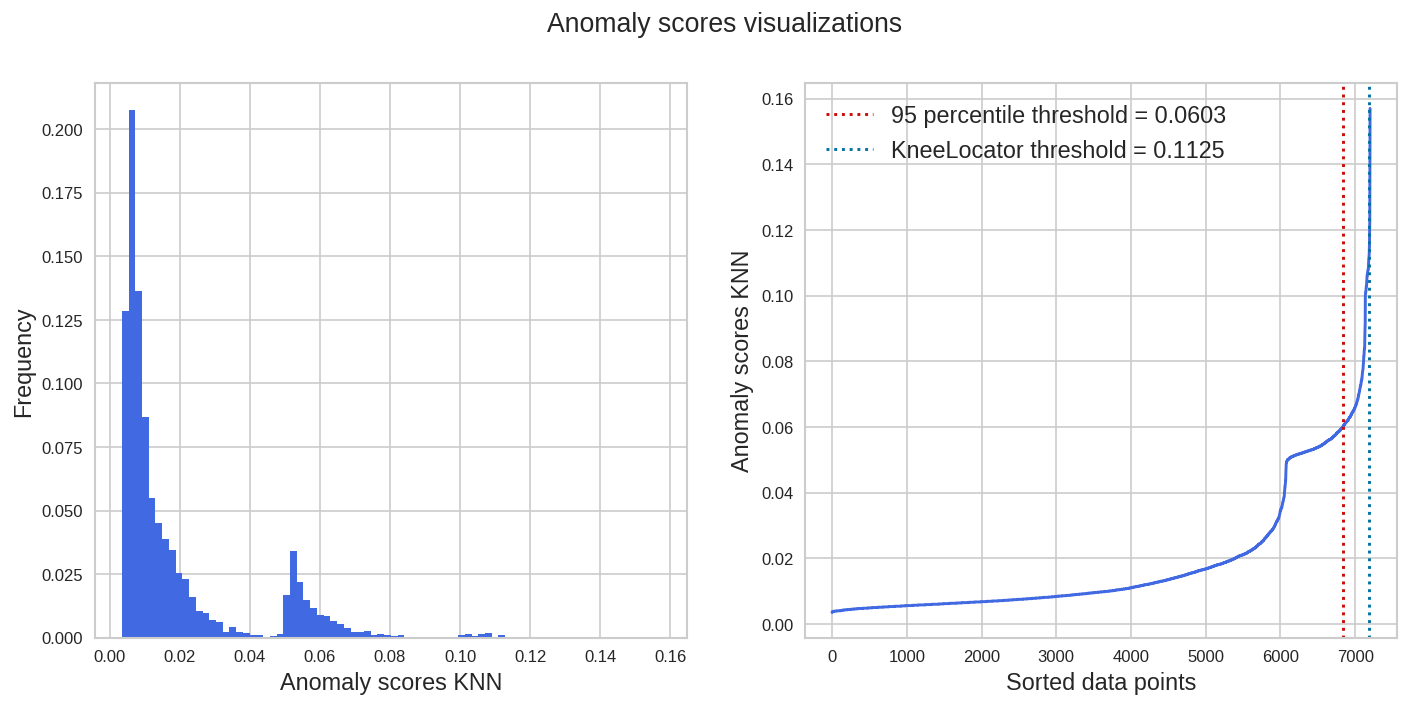

In [ ]:
# Plot anomaly scores

Anomalyplot(sorted_scores_KNN, anomaly_thresholds = [threshold_perc_KNN, threshold_knee_KNN], algorithm ="KNN")

> We choose to consider anomaly an observation if it has an anomaly score higher than the 95% of the data points.

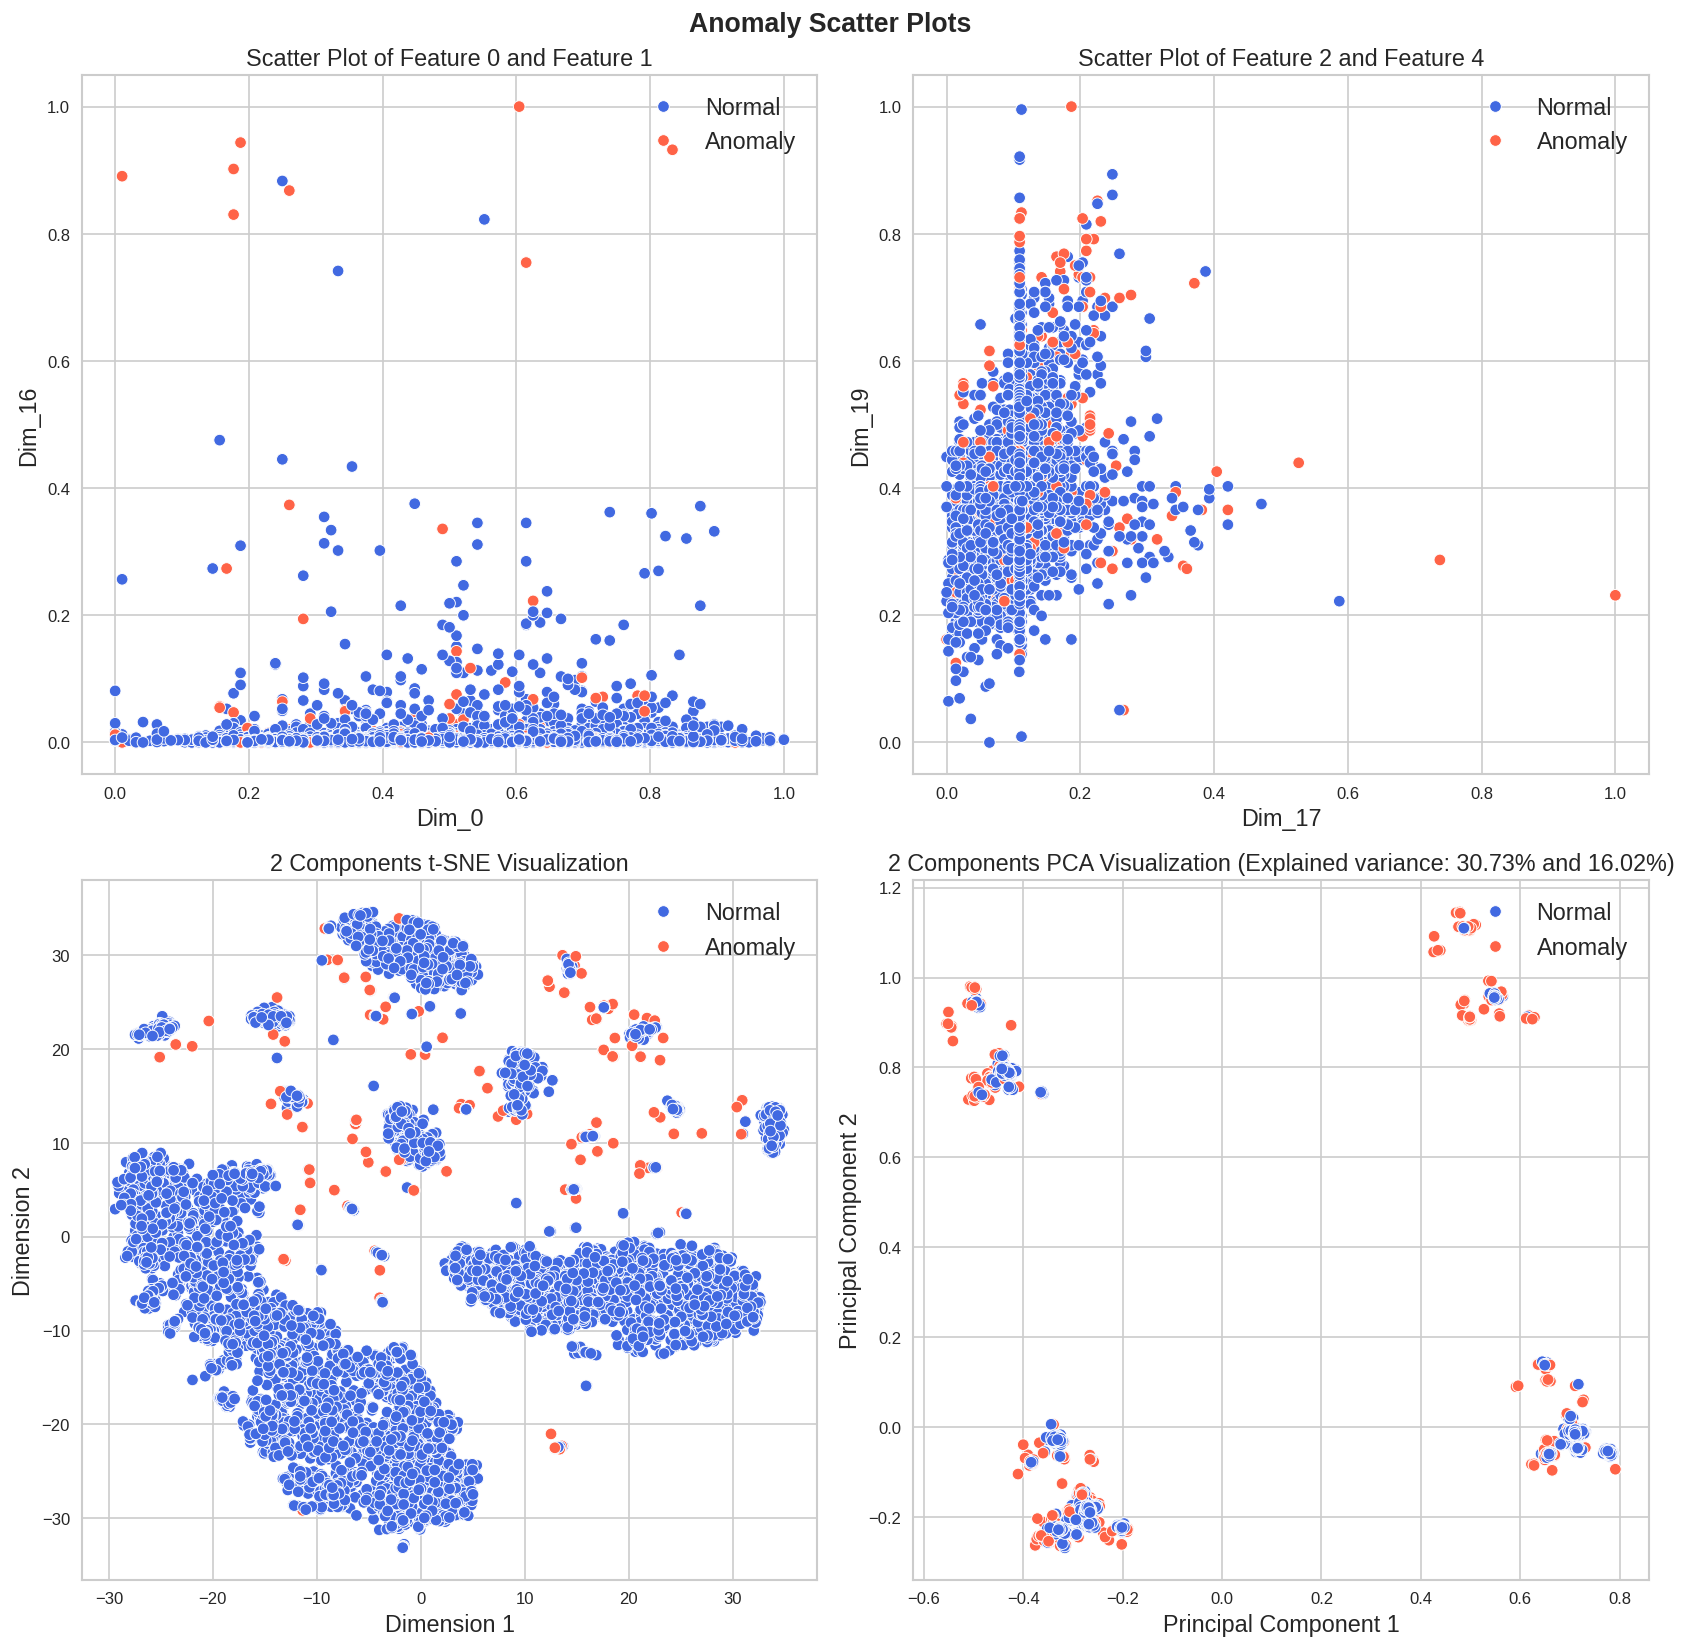

In [ ]:
# Plot anomaly scatter plots

AnomalyScatterplots(df, anomalies_idxs_perc_KNN, palette = ["royalblue","tomato"])

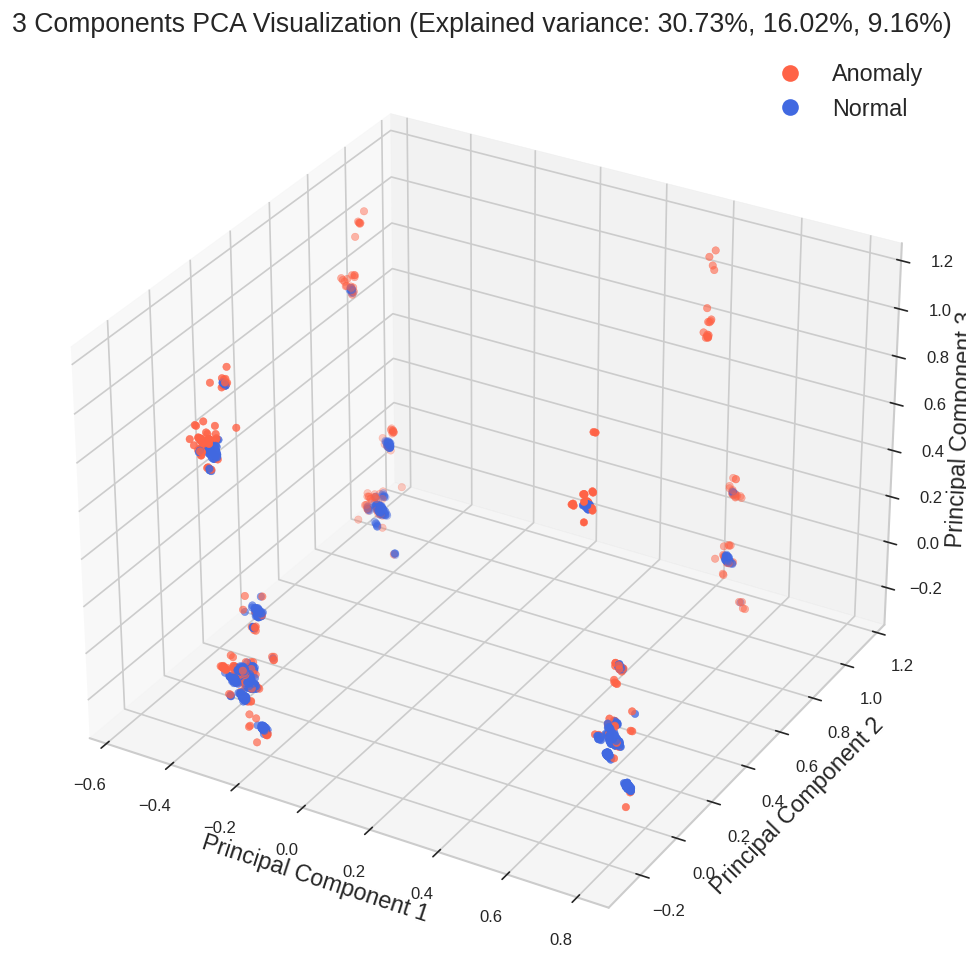

In [ ]:
# 3-components PCA

PCA3dscatter(df, anomalies_idxs_perc_KNN)
#PCA3dscatterITERATIVE(df, anomalies_idxs_perc_KNN)

### 2. **LOF** - _proximity, density based_

**KEY ASSUMPTION:** Normal data objects have close neighbors, while anomalies are data objects in low density regions.





In [ ]:
# Parameters:

n_neighbors = int(np.sqrt(N))                # Number of neighbors to consider, √n usually leads to good results
S = 1                                        # Sensitivity parameter KneeLocator

# Previously defined function

anomaly_scores_LOF = LOF(gower_distance_matrix, n_neighbors)

# Zip the lof scores with the idxs = np.arange(N) in order to sort the indices

idxs = np.arange(N).tolist()

combined = list(zip(anomaly_scores_LOF, idxs))
sorted_anomalies = sorted(combined, key=lambda x: x[0])
sorted_scores_LOF, sorted_idxs_LOF = zip(*sorted_anomalies)

#-------------------------------------------------------------------------------

# Identify anomalies USING PERCENTILES

threshold_perc_LOF = np.percentile(sorted_scores_LOF, 95).astype("float64")

# Identify anomalies USING KNEE LOCATOR

kneedle = KneeLocator(range(N), sorted_scores_LOF, S=S, curve='convex', direction='increasing')
knee_point = kneedle.elbow
threshold_knee_LOF = sorted_scores_LOF[knee_point].astype("float64")


# Saving anomalies, idxs and not anomalies
anomalies_perc_LOF = np.where(sorted_scores_LOF > threshold_perc_LOF)[0]
anomalies_knee_LOF = np.where(sorted_scores_LOF > threshold_knee_LOF)[0]

anomalies_idxs_perc_LOF = sorted_idxs_LOF[-len(anomalies_perc_LOF):]
anomalies_idxs_knee_LOF = sorted_idxs_LOF[-len(anomalies_knee_LOF):]


# Array for majority vote
anomalies_LOF= np.ones(N)
anomalies_LOF[list(anomalies_idxs_perc_LOF)] = -1


print("LOF anomaly scores sample:", np.array(sorted_scores_LOF))
print("N° of top 5% anomalies:", len(anomalies_perc_LOF))
print("N° of KneeLocator anomalies:", len(anomalies_knee_LOF))

LOF anomaly scores sample: [ 0.70492519  0.70492519  0.70492519 ...  9.61586035 12.4162807
 13.20578997]
N° of top 5% anomalies: 360
N° of KneeLocator anomalies: 117


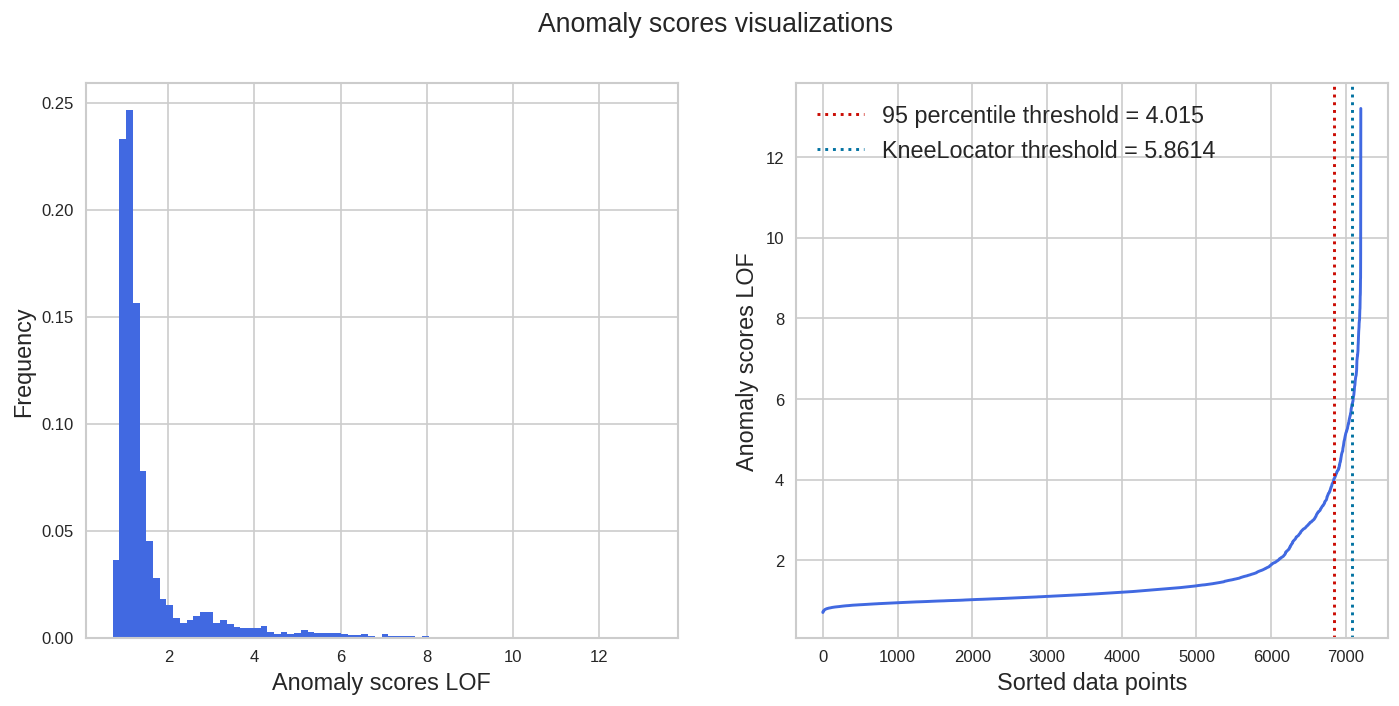

In [ ]:
# Plot anomaly scores

Anomalyplot(sorted_scores_LOF, anomaly_thresholds = [threshold_perc_LOF, threshold_knee_LOF], algorithm ="LOF")

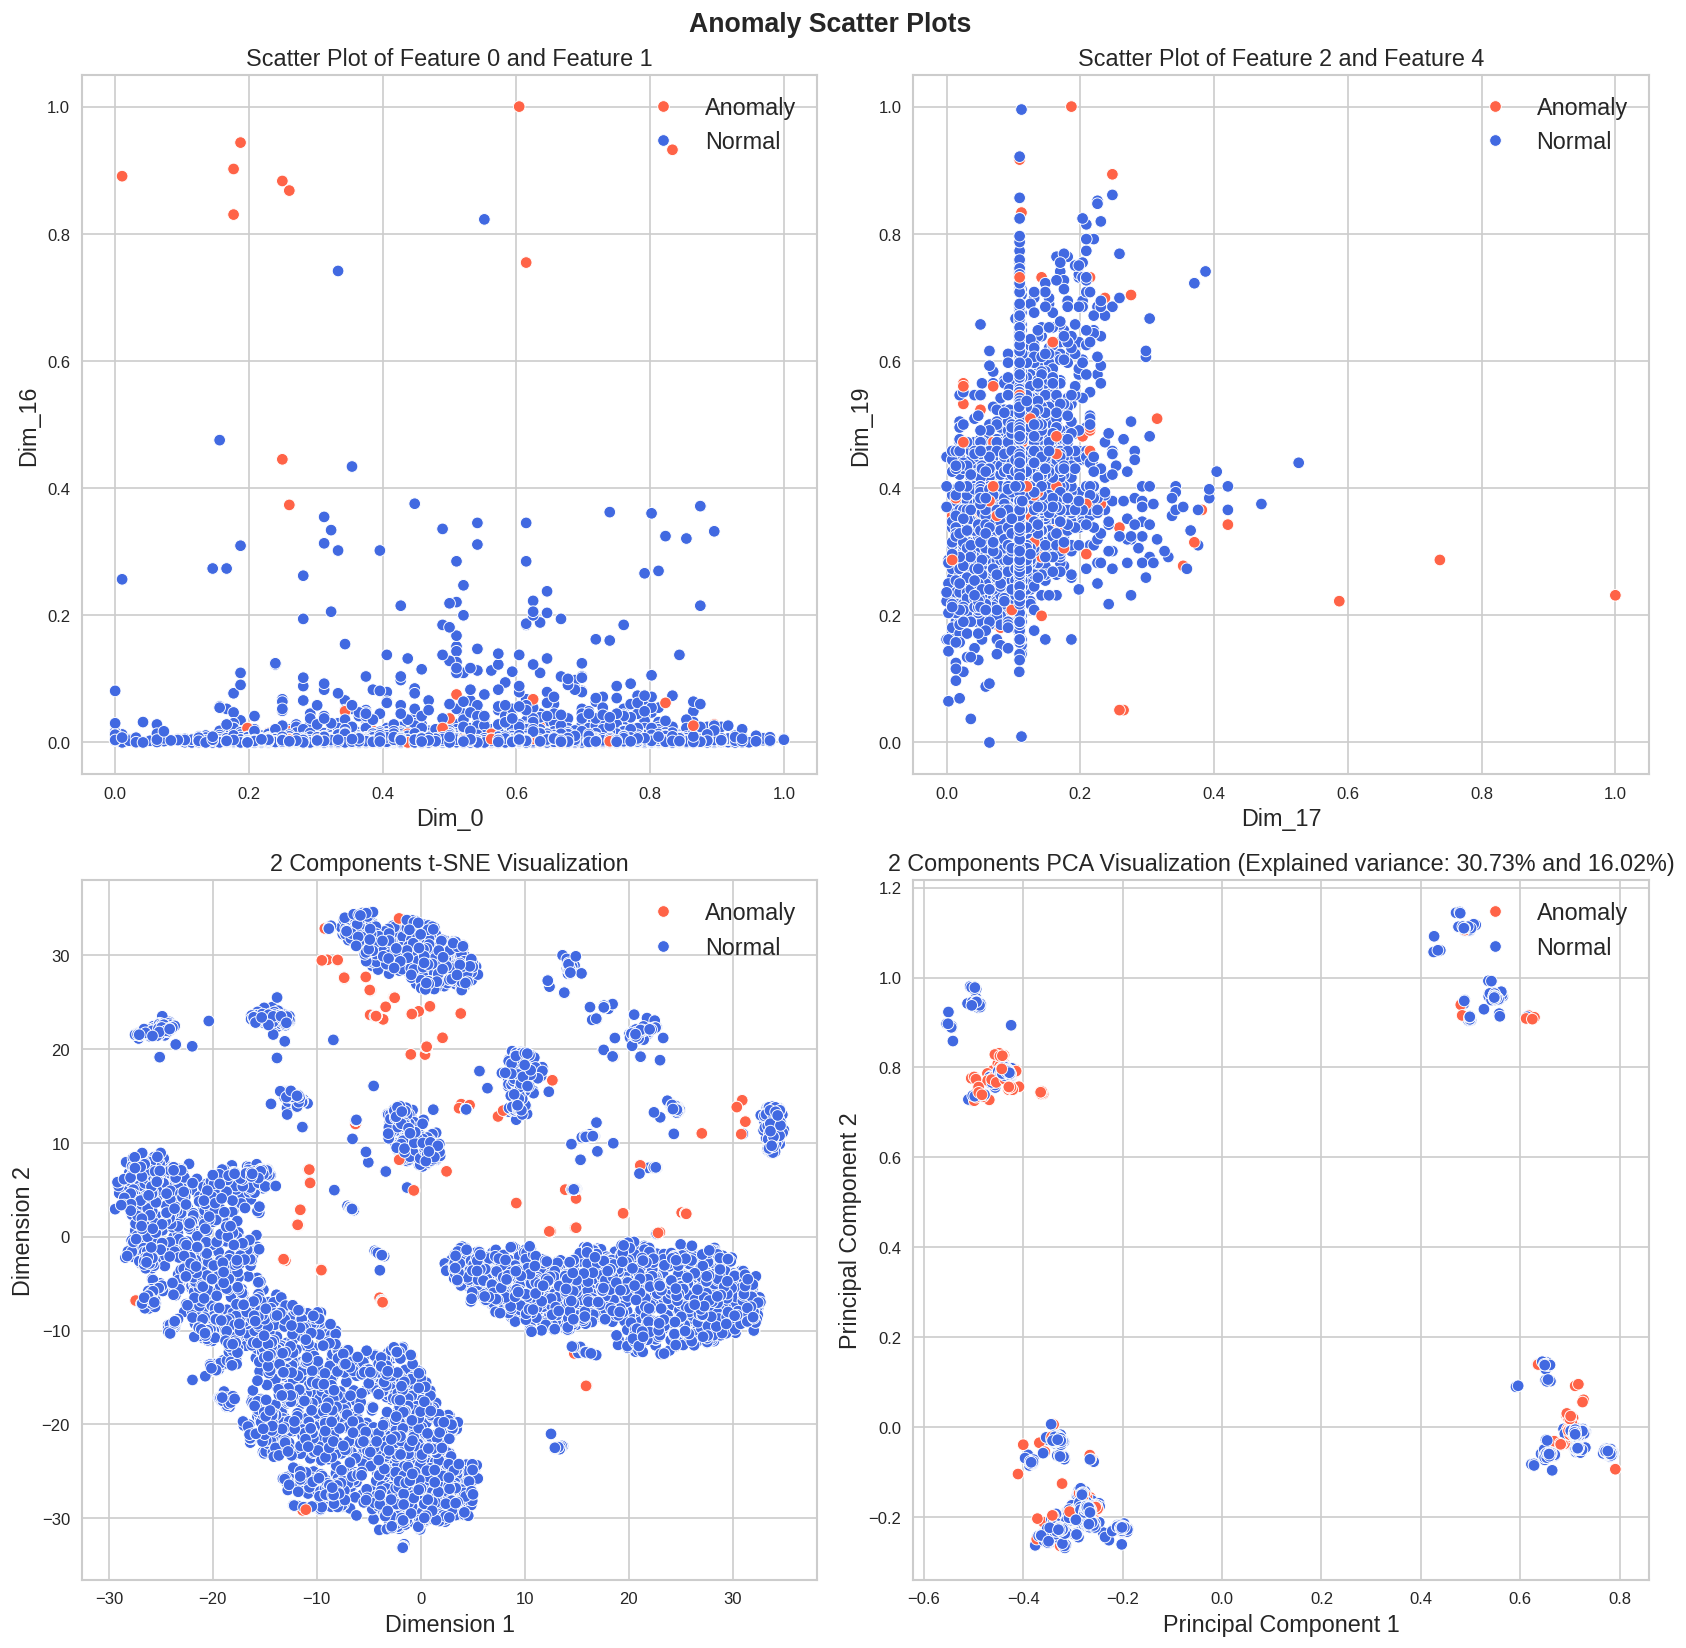

In [ ]:
# Plot anomaly scatter plots

AnomalyScatterplots(df, anomalies_idxs_perc_LOF)

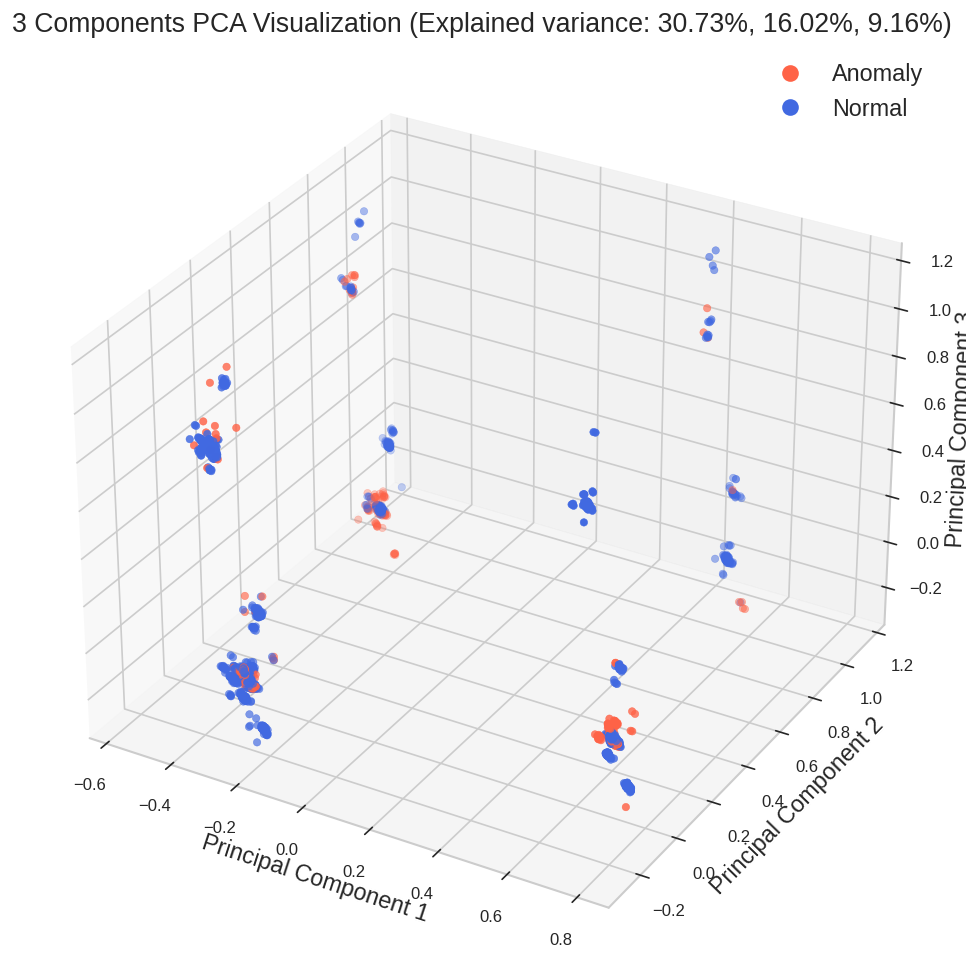

In [ ]:
# 3-components PCA

PCA3dscatter(df, anomalies_idxs_perc_LOF)
#PCA3dscatterITERATIVE(df, anomalies_idxs_perc_LOF)

### 3. **DBSCAN** - _clustering based_

**KEY ASSUMPTION:** Normal data instances belong to large and dense clusters, while anomalies do not belong to any significant cluster.

> While Kmeans requires to be fit on a sparse matrix, DBSCAN can be fit on a precomputed distance matrix.

In [ ]:
dbscan = DBSCAN(eps = 0.05, min_samples=int(np.sqrt(N)), metric = "precomputed").fit(gower_distance_matrix)  #, min_samples=int(np.sqrt(N))


'''
eps : float, default=0.5
        The maximum distance between two samples for one to be considered
        as in the neighborhood of the other. This is not a maximum bound
        on the distances of points within a cluster. This is the most
        important DBSCAN parameter to choose appropriately for your data set
        and distance function.

min_samples : int, default=5
        The number of samples (or total weight) in a neighborhood for a point to
        be considered as a core point. This includes the point itself. If
        `min_samples` is set to a higher value, DBSCAN will find denser clusters,
        whereas if it is set to a lower value, the found clusters will be more
        sparse.
'''

Counter(dbscan.labels_).most_common()

[(0, 6634), (-1, 566)]

In [ ]:
# We can try to consider anomaly every observation that is not in the main cluster

anomaly_clusters = [ x[0] for x in Counter(dbscan.labels_).most_common()[1:]]

anomalies_idxs_DBSCAN = []
label_dict = dict(zip(np.arange(N), dbscan.labels_))
for idx in label_dict:
  if label_dict[idx] in anomaly_clusters:
    anomalies_idxs_DBSCAN.append(idx)

print("N° of detected anomalies:", len(anomalies_idxs_DBSCAN))

# Array for majority vote
anomalies_DBSCAN = np.ones(N)
anomalies_DBSCAN[list(anomalies_idxs_DBSCAN)] = -1

N° of detected anomalies: 566


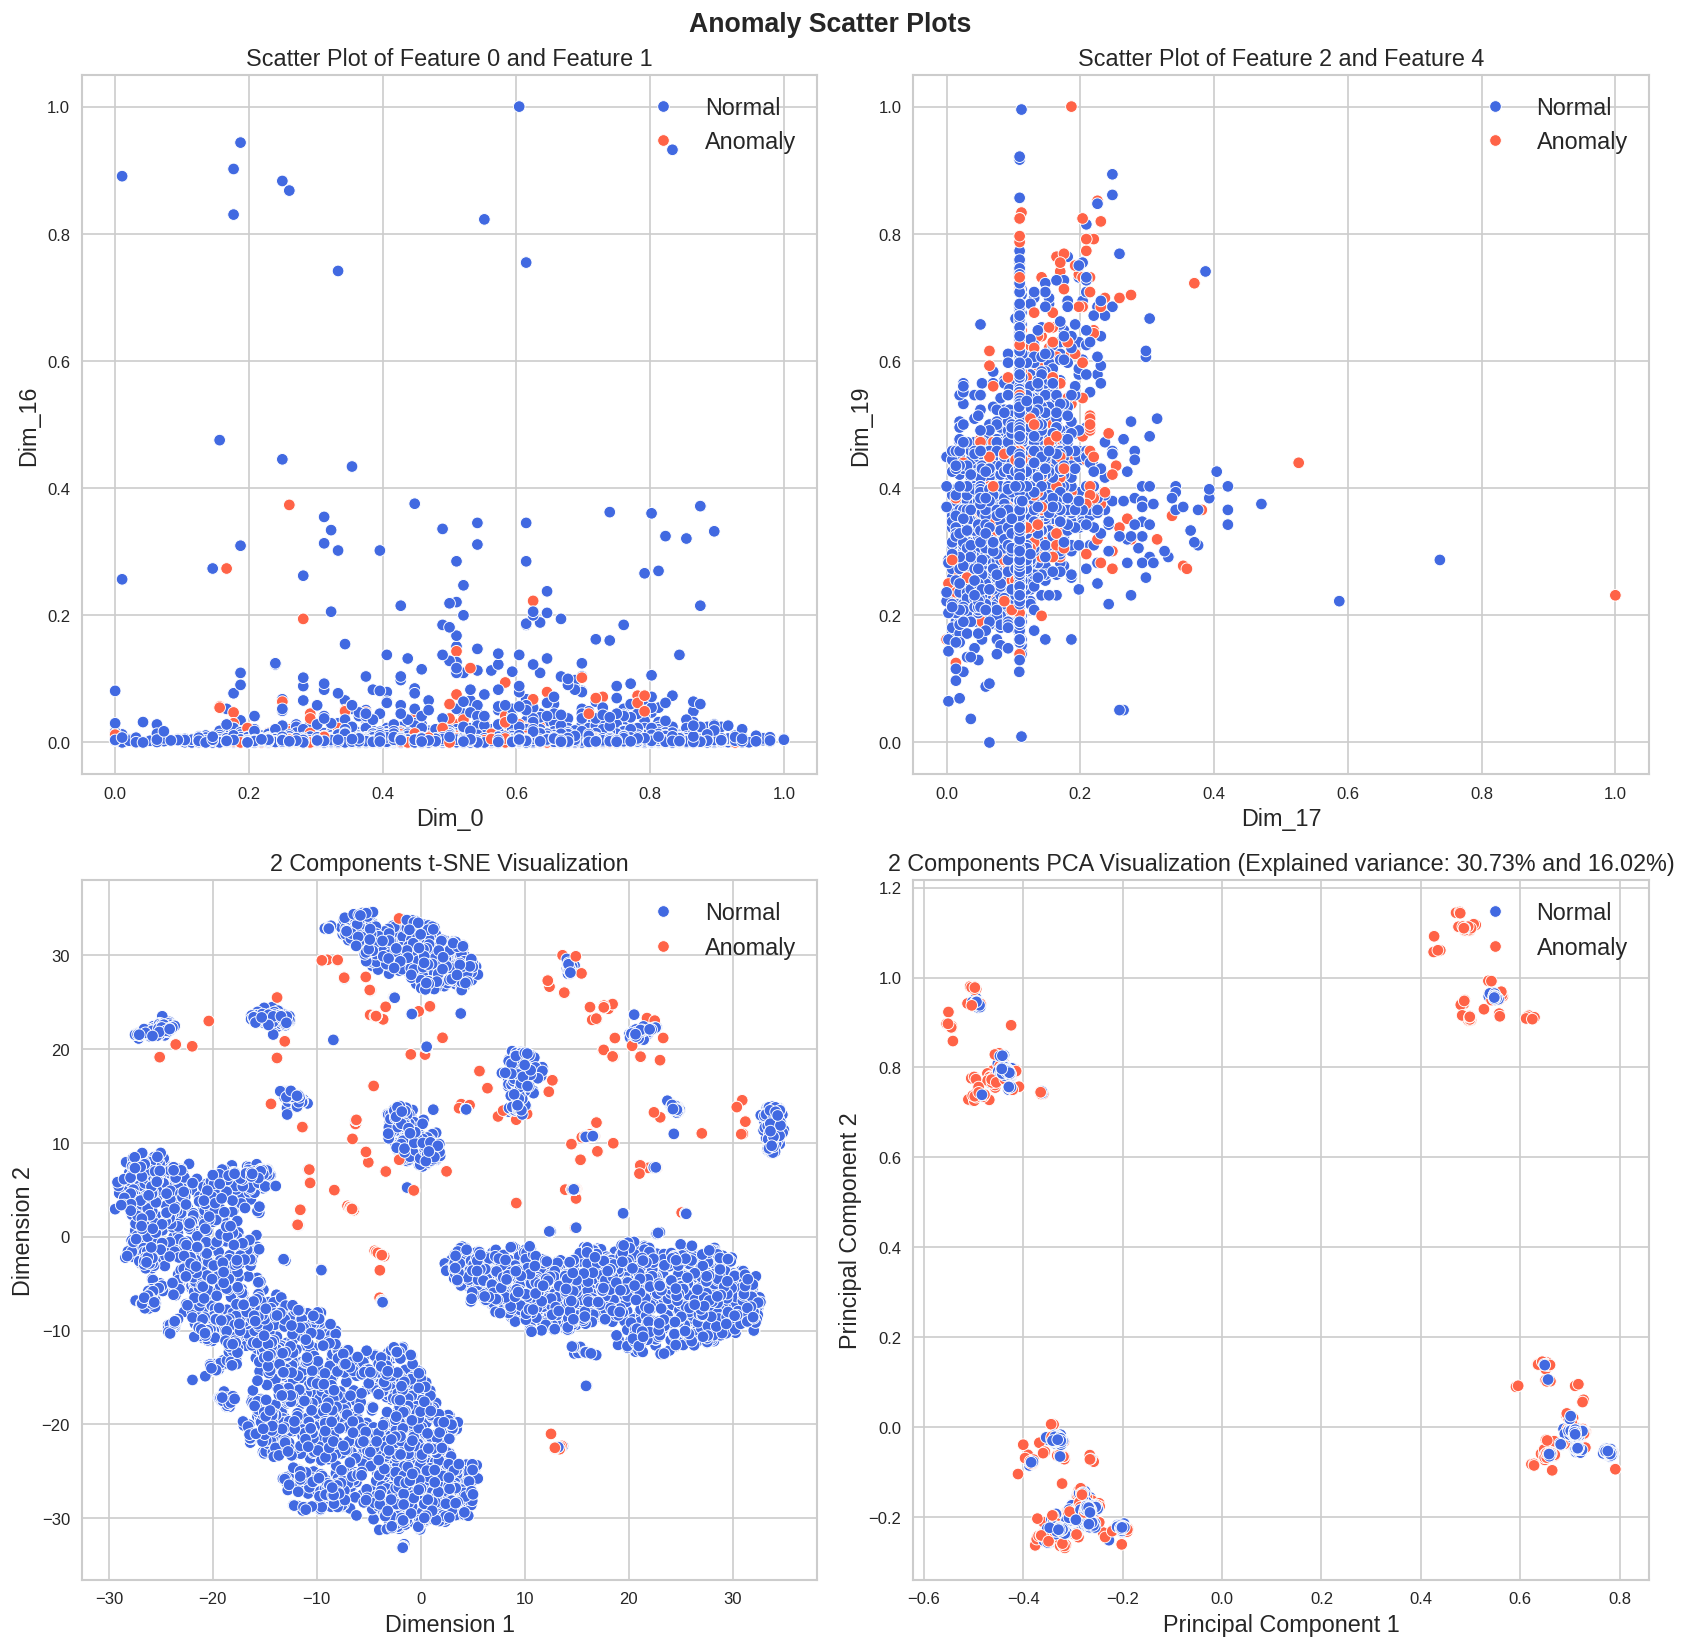

In [ ]:
# Plot anomaly scatterplots

AnomalyScatterplots(df, tuple(anomalies_idxs_DBSCAN), palette = ["royalblue","tomato"])

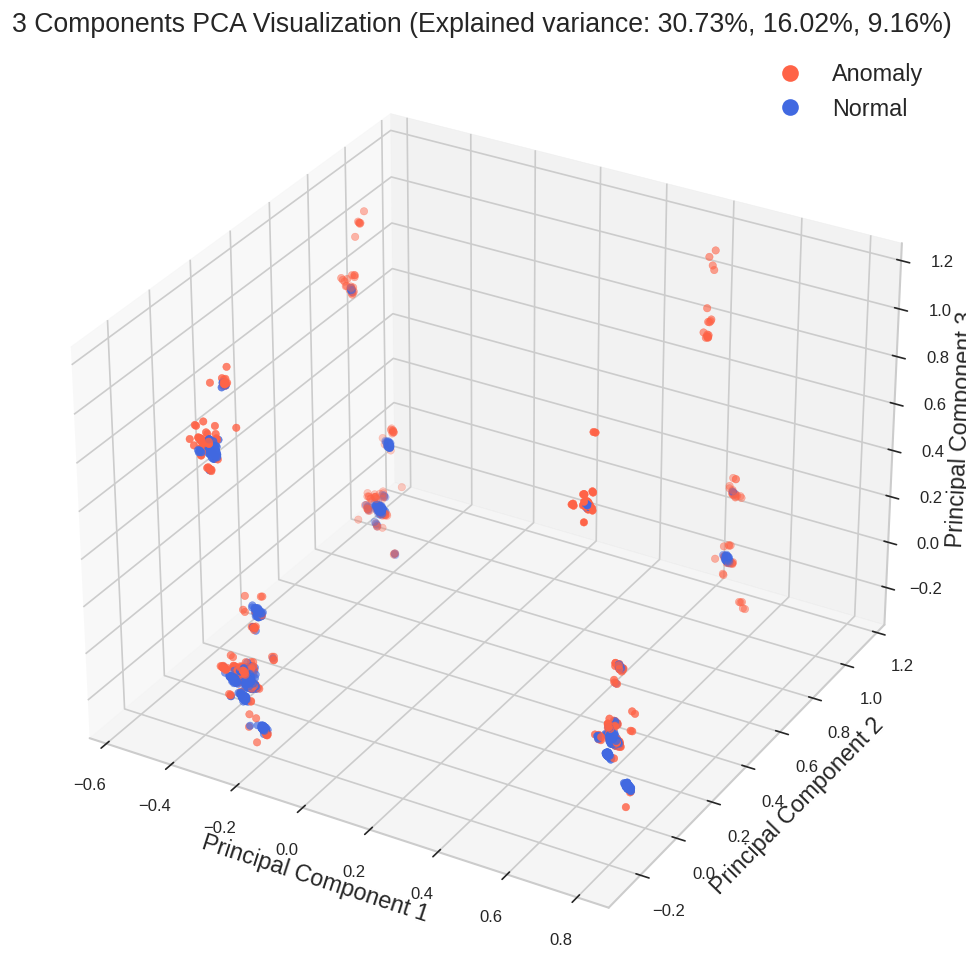

In [ ]:
# 3-components PCA

PCA3dscatter(df, anomalies_idxs_DBSCAN)
#PCA3dscatterITERATIVE(df, anomalies_idxs_DBSCAN)

### 4. **PCA** - _reconstruction based_

**KEY ASSUMPTION:** There are patterns in the distribution of the normal class that can be captured using lower-dimensional representations. By comparing the original data with its reconstructed reduced-dimensional version, anomalies can be detected through significant differences.

In [ ]:
components = 7

pca = PCA(n_components=components)

X = pca.fit_transform(df)

reconstruction = pca.inverse_transform(X)

print(f"N° of PCA components: {len(X[0])}")
print(f"N° of reconstructed features: {len(reconstruction[0])}")

print(f"Explained variance: {np.sum(pca.explained_variance_ratio_ * 100).round(2)}%")

N° of PCA components: 7
N° of reconstructed features: 21
Explained variance: 81.6%


In [ ]:
# Let's compute the reconstruction error

reconstruction_error = np.sum((df - reconstruction) ** 2, axis=1)

RE_mean = reconstruction_error.mean()
RE_std  = reconstruction_error.std()
print(f"Mean reconstruction error : {RE_mean.round(2)}\nStandard deviation: {RE_std.round(2)}")

Mean reconstruction error : 0.13
Standard deviation: 0.32


In [ ]:
# Parameters:

S = 1                                     # Sensitivity parameter KneeLocator

# Zip the reconstruction errors with the idxs = np.arange(N) in order to sort the indices

idxs = np.arange(N).tolist()

combined = list(zip(reconstruction_error, idxs))
sorted_distances = sorted(combined, key=lambda x: x[0])
sorted_scores_PCA, sorted_idxs_PCA = zip(*sorted_distances)

#-------------------------------------------------------------------------------

# Identify anomalies USING PERCENTILES

threshold_perc_PCA = np.percentile(sorted_scores_PCA, 95).astype("float64")   # Top 5% as anomalies

# Identify anomalies USING KNEE LOCATOR

kneedle = KneeLocator(range(N), sorted_scores_PCA, S=S, curve='convex', direction='increasing')
knee_point = kneedle.elbow
threshold_knee_PCA = np.float64(sorted_scores_PCA[knee_point]) #.astype("float64")

# MANUALLY chosen threshold
anomalies_man_PCA = np.where(sorted_scores_PCA > np.float64(0.2))[0]
anomalies_idxs_man_PCA = sorted_idxs_PCA[-len(anomalies_man_PCA):]

# Saving anomalies, idxs and not anomalies
anomalies_perc_PCA = np.where(sorted_scores_PCA > threshold_perc_PCA)[0]
anomalies_knee_PCA = np.where(sorted_scores_PCA > threshold_knee_PCA)[0]

anomalies_idxs_perc_PCA = sorted_idxs_PCA[-len(anomalies_perc_PCA):]
anomalies_idxs_knee_PCA = sorted_idxs_PCA[-len(anomalies_knee_PCA):]

# Array for majority vote
anomalies_PCA = np.ones(N)
anomalies_PCA[list(anomalies_idxs_man_PCA)] = -1          # i use manually chosen threshold!


print("PCA anomaly scores sample:", np.array(sorted_scores_PCA))
print("N° of top 5% anomalies:", len(anomalies_perc_PCA))
print("N° of KneeLocator anomalies:", len(anomalies_knee_PCA))
print("N° of manually thresholded anomalies:", len(anomalies_man_PCA))

PCA anomaly scores sample: [1.06502846e-03 1.13512322e-03 1.21867911e-03 ... 2.04689388e+00
 2.08807762e+00 2.15253897e+00]
N° of top 5% anomalies: 360
N° of KneeLocator anomalies: 102
N° of manually thresholded anomalies: 839


> _Approach:_ we use a threshold because "Objects with large reconstruction errors are anomalies". Alternatively, we could have employed an approach based on Chi-square distribution.

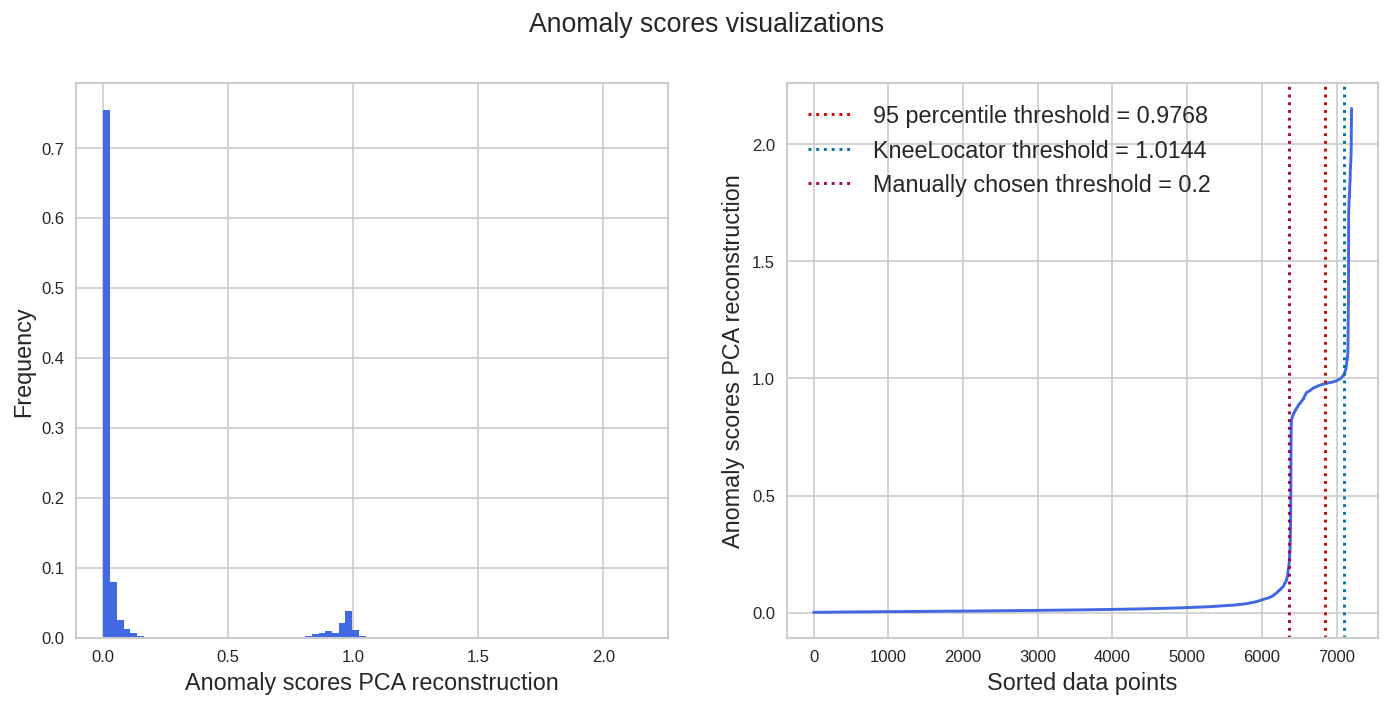

In [ ]:
# Plot anomaly scores

Anomalyplot(sorted_scores_PCA, anomaly_thresholds = [threshold_perc_PCA, threshold_knee_PCA, np.float64(0.2)],
            algorithm ="PCA reconstruction", t_labels = ['95 percentile threshold', 'KneeLocator threshold', 'Manually chosen threshold'])

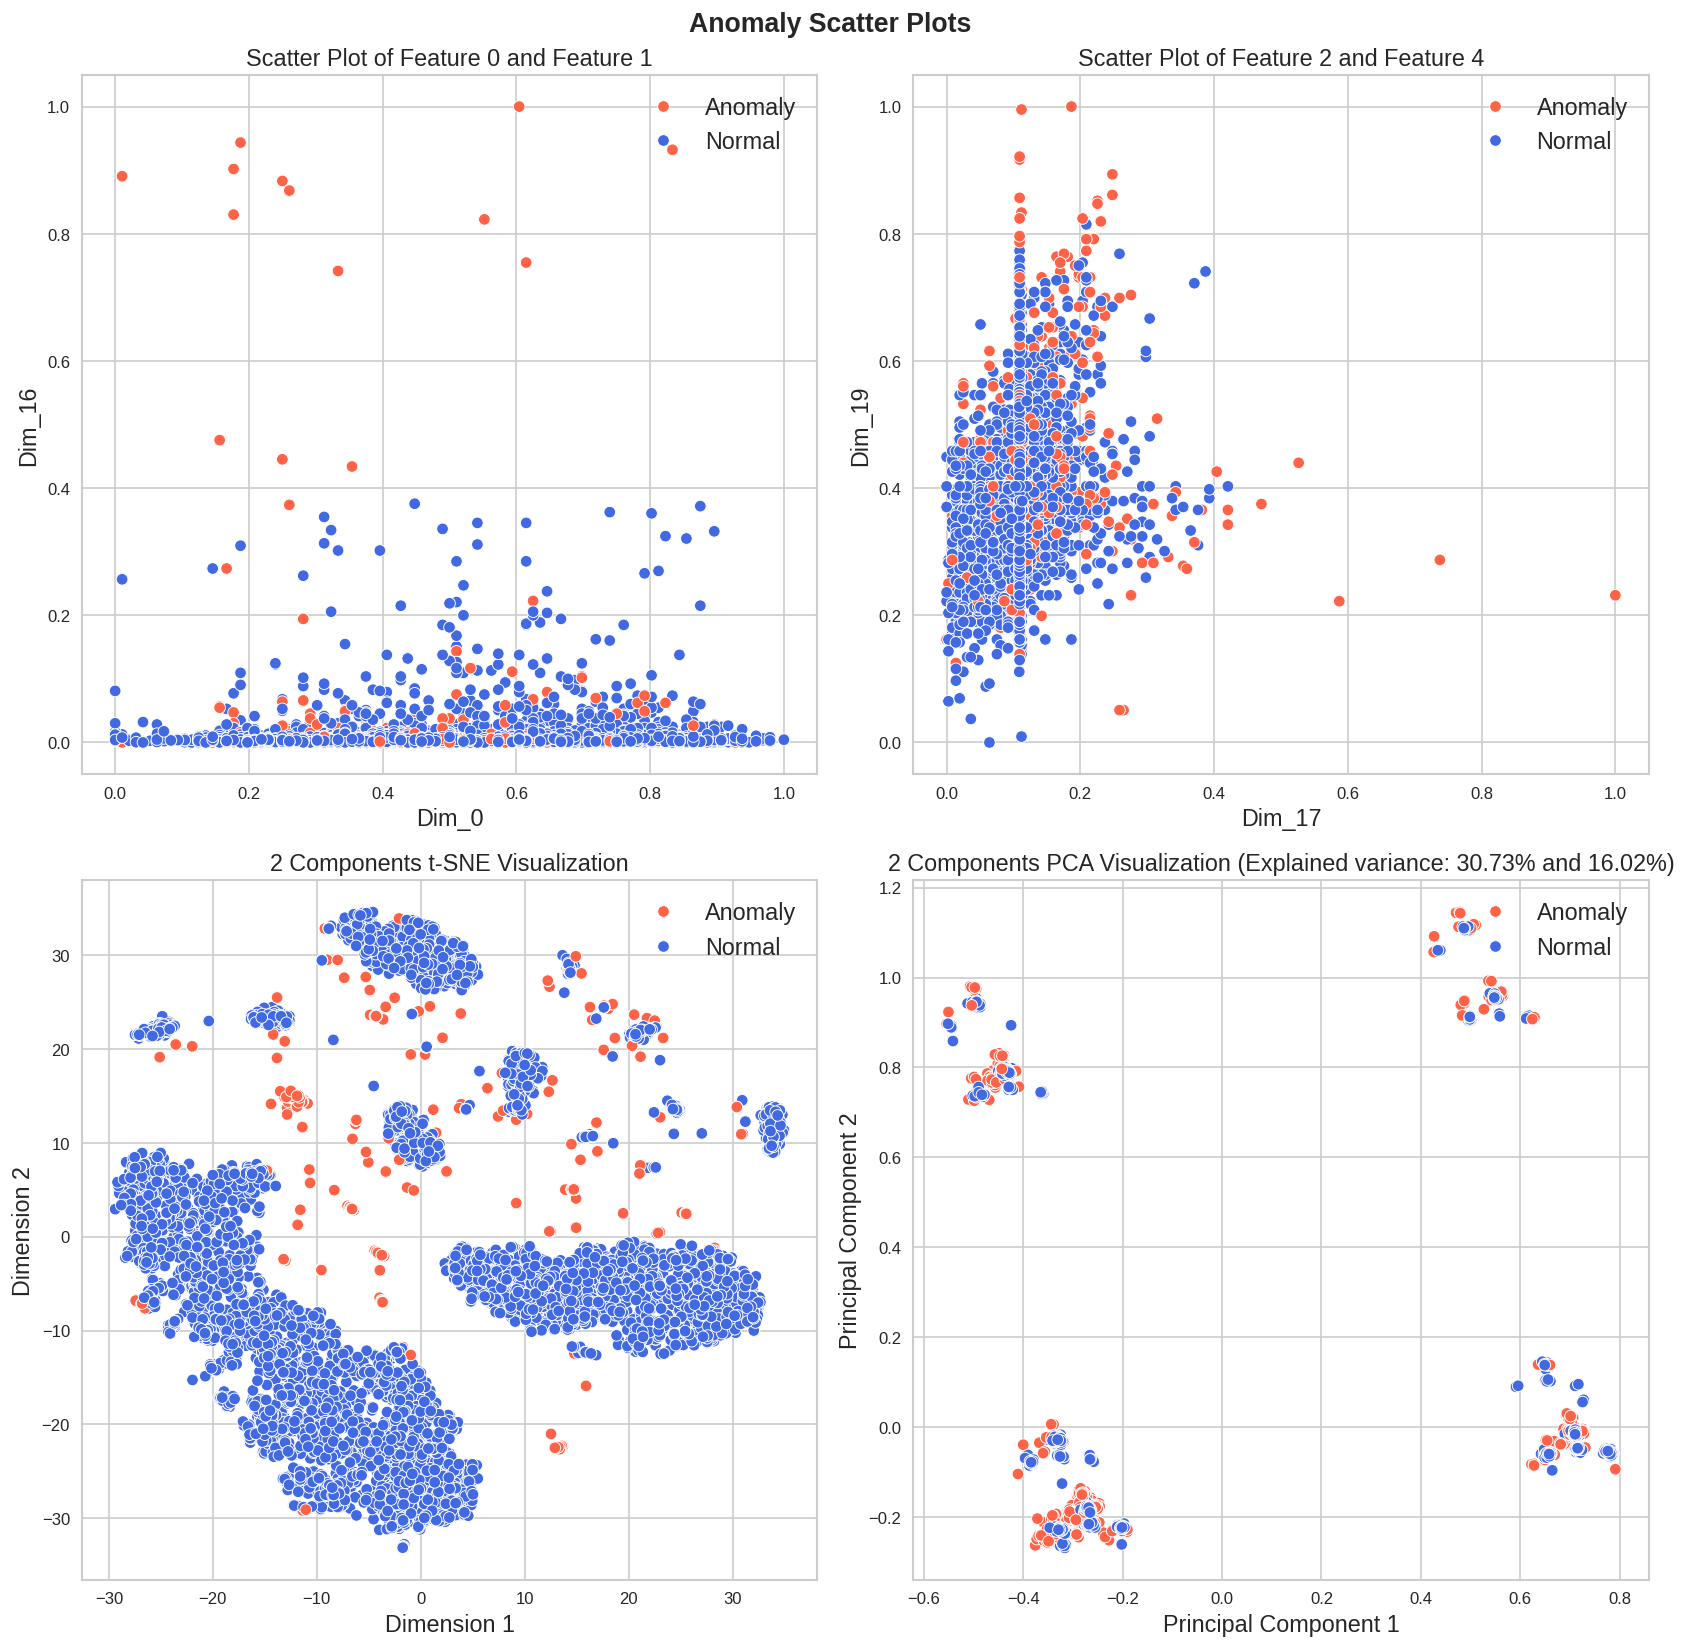

In [ ]:
# Plot anomaly scatter plots

AnomalyScatterplots(df, anomalies_idxs_man_PCA)

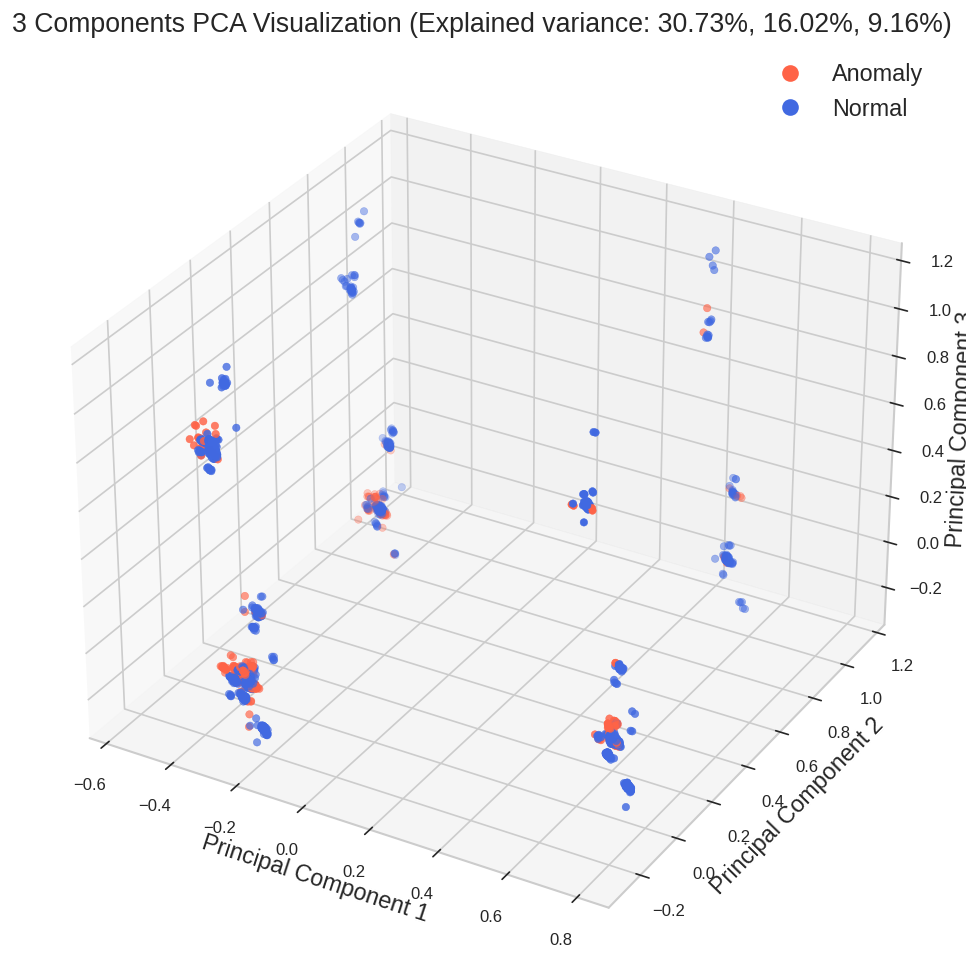

In [ ]:
# 3-components PCA

PCA3dscatter(df, anomalies_idxs_perc_PCA)
#PCA3dscatterITERATIVE(df, anomalies_idxs_perc_PCA)

### 5. **One Class SVM** - _SVM based_

**KEY ASSUMPTION:** The boundary of normal data objects can be learnt using a support vector machines approach, by projecting the data to a higher dimensional space where anomalies and normal points can be linearly separated.

In [ ]:
anomaly_preds = OneClassSVM(gamma='auto', nu=0.05).fit_predict(df)


'''
nu: An upper bound on the fraction of training errors and a lower bound of the fraction of support vectors.
    Should be in the interval (0, 1]. By default 0.5 will be taken.
'''

anomaly_idxs_SVM = np.where(anomaly_preds == -1)[0]

# mask to use for majority vote
anomalies_SVM = np.ones(N)
anomalies_SVM[list(anomaly_idxs_SVM)] = -1

print("N° of SVM anomalies:", len(anomaly_idxs_SVM))

N° of SVM anomalies: 359


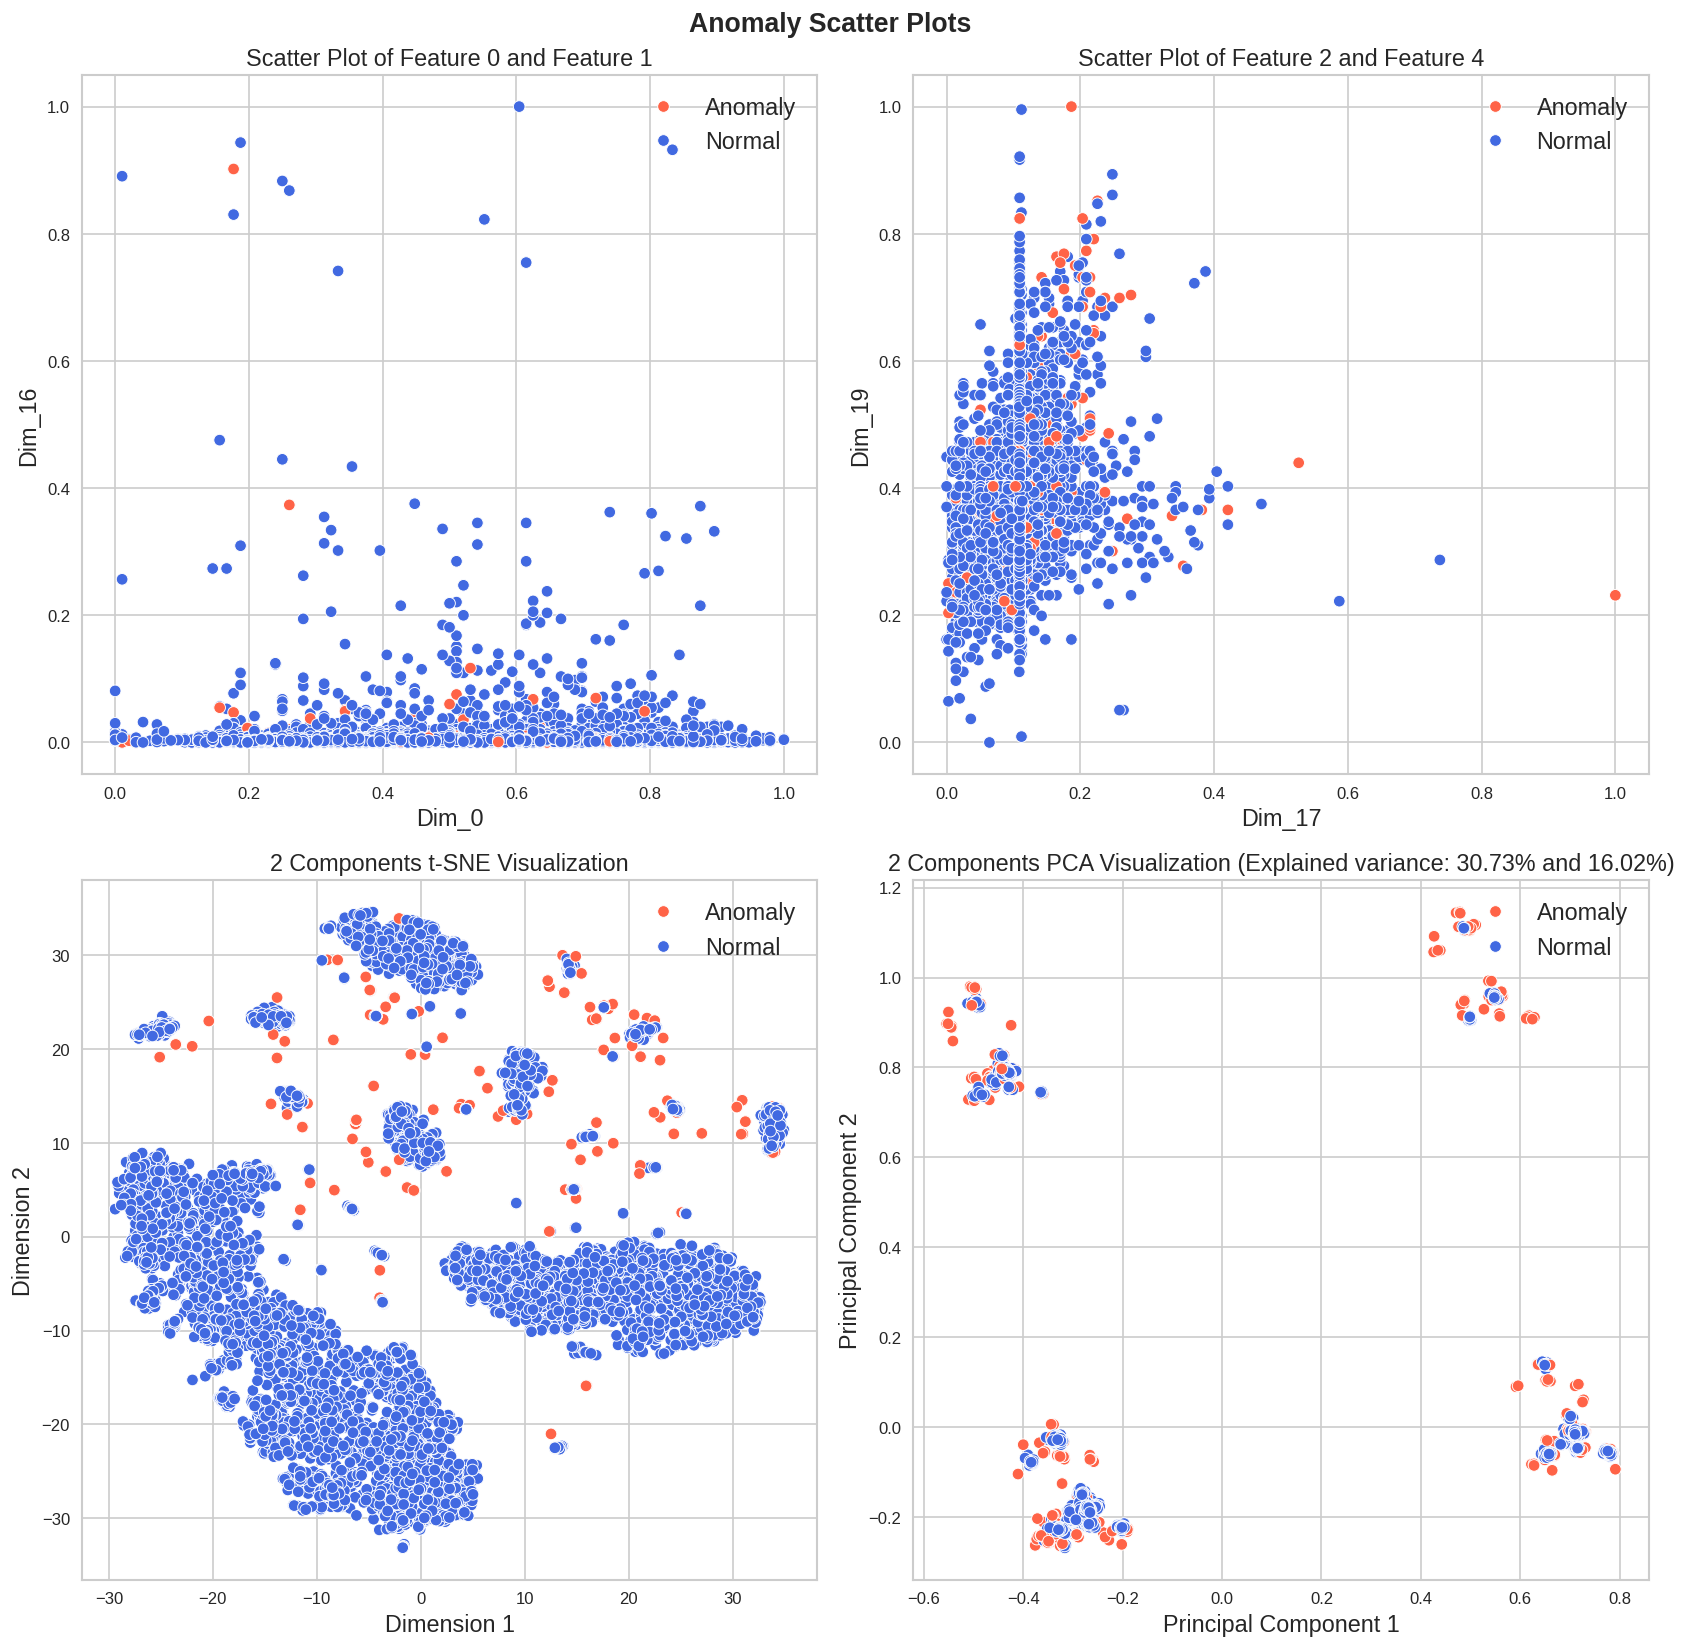

In [ ]:
# Plot anomaly scatter plots

AnomalyScatterplots(df, anomaly_idxs_SVM)

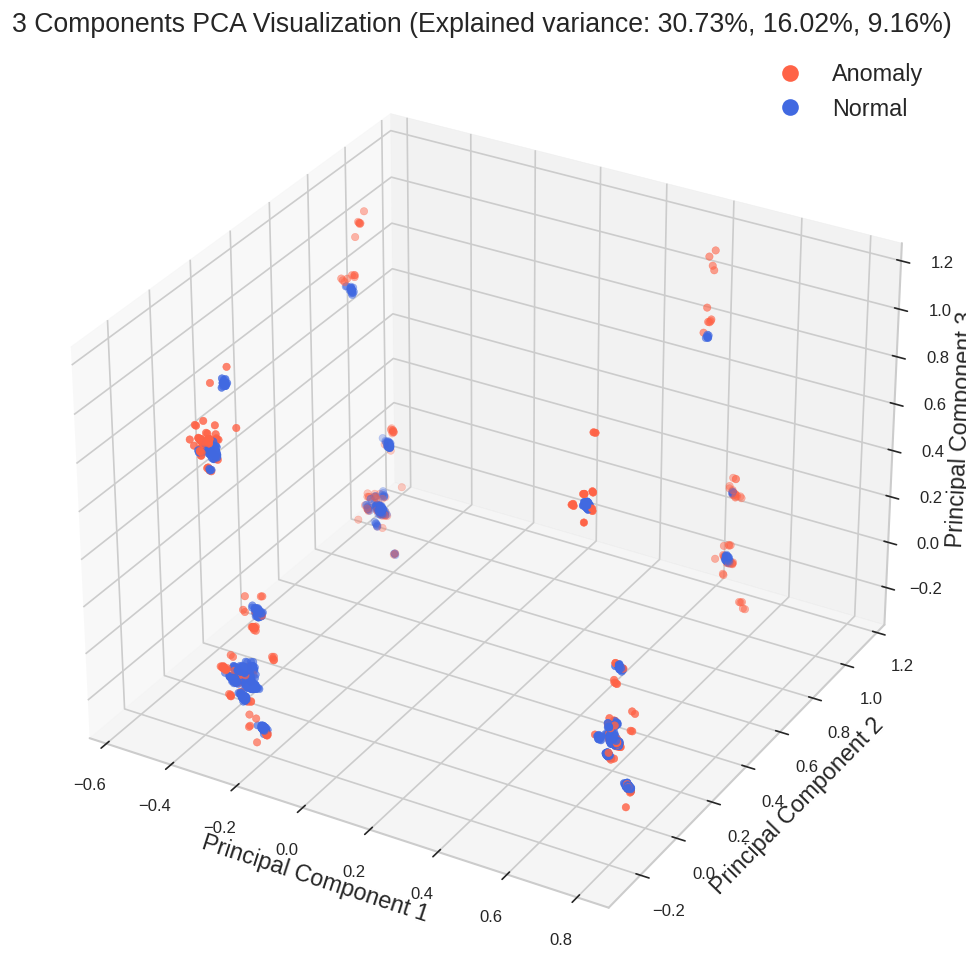

In [ ]:
# 3-components PCA

PCA3dscatter(df, anomaly_idxs_SVM)
#PCA3dscatterITERATIVE(df, anomaly_idxs_SVM)

### *__Majority vote__*

> Since we don't have **ground truth** labels for our data, we can consider all the algorithms discussed above and combine their results using a **majority vote** approach. This method helps balance the weaknesses of individual models and gives a more reliable way to identify anomalies.

In [ ]:
methods = np.stack([anomalies_KNN, anomalies_LOF, anomalies_DBSCAN, anomalies_PCA, anomalies_SVM])

count = np.sum(methods == -1, axis=0)

majority_vote = np.where(count >= 3, -1, 1)  # if at least 3 algorithms agree, that's an anomaly

anomalies = np.where(majority_vote == -1)[0]
print(f"N° of anomalies {len(anomalies)}")

N° of anomalies 425


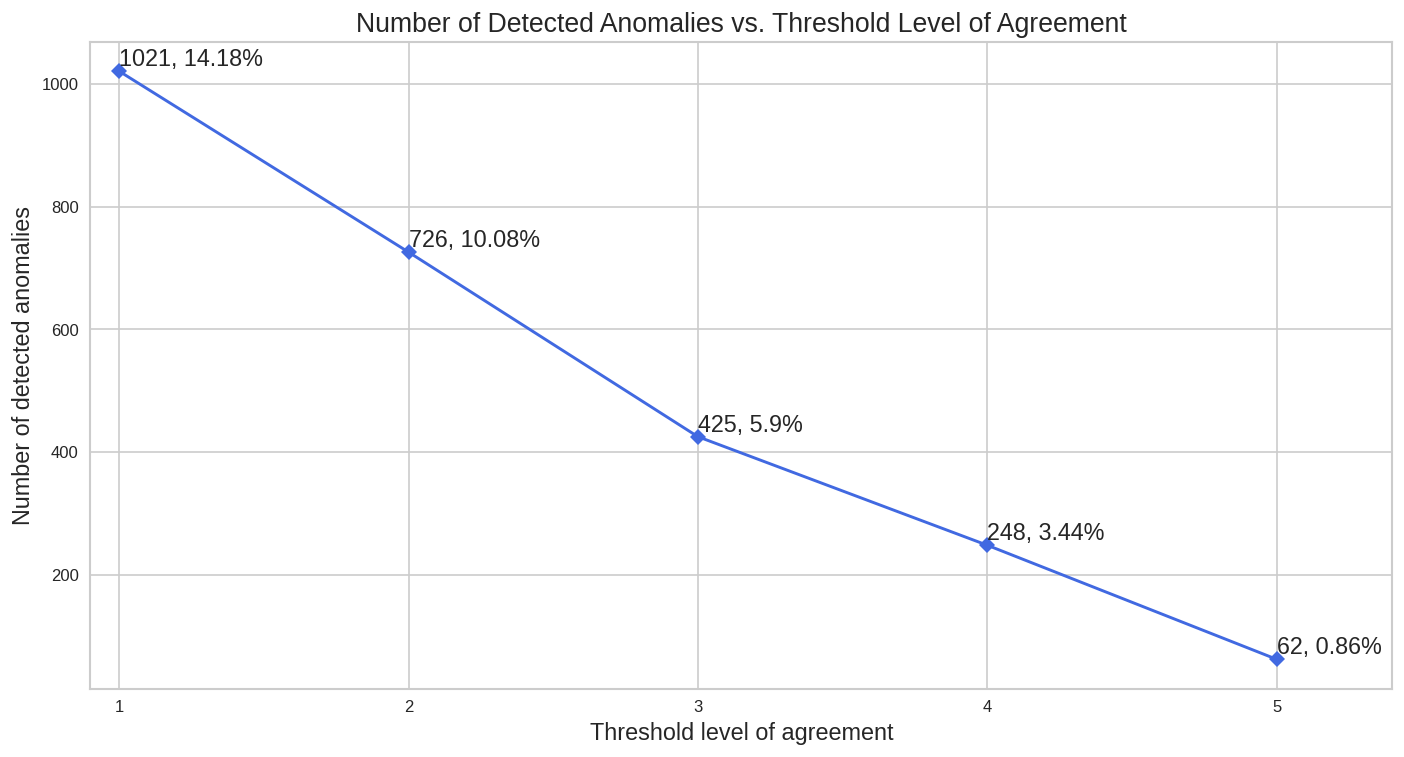

In [ ]:
# plot

thresholds = np.arange(1, methods.shape[0] + 1)

num_anomalies = []
for threshold in thresholds:
    majority_vote_plot = np.where(count >= threshold, -1, 1)
    anomalies_plot = np.where(majority_vote_plot == -1)[0]
    num_anomalies.append(len(anomalies_plot))

# Plotting
plt.figure(figsize=(14, 7), dpi=120)
plt.plot(thresholds, num_anomalies, marker='D', linestyle='-', color=color)
for threshold, num_anomaly in zip(thresholds, num_anomalies):
    plt.text(threshold, num_anomaly, f"{num_anomaly}, {np.round(num_anomaly/N*100,2)}%", ha='left', va='bottom', fontsize=14)

plt.title("Number of Detected Anomalies vs. Threshold Level of Agreement", fontsize = 16)
plt.xlabel("Threshold level of agreement", fontsize = 14)
plt.ylabel("Number of detected anomalies", fontsize = 14)
plt.xlim(0.9, 5.4)
plt.grid(True)
plt.xticks(thresholds)
plt.savefig("agreement.png")
plt.show()

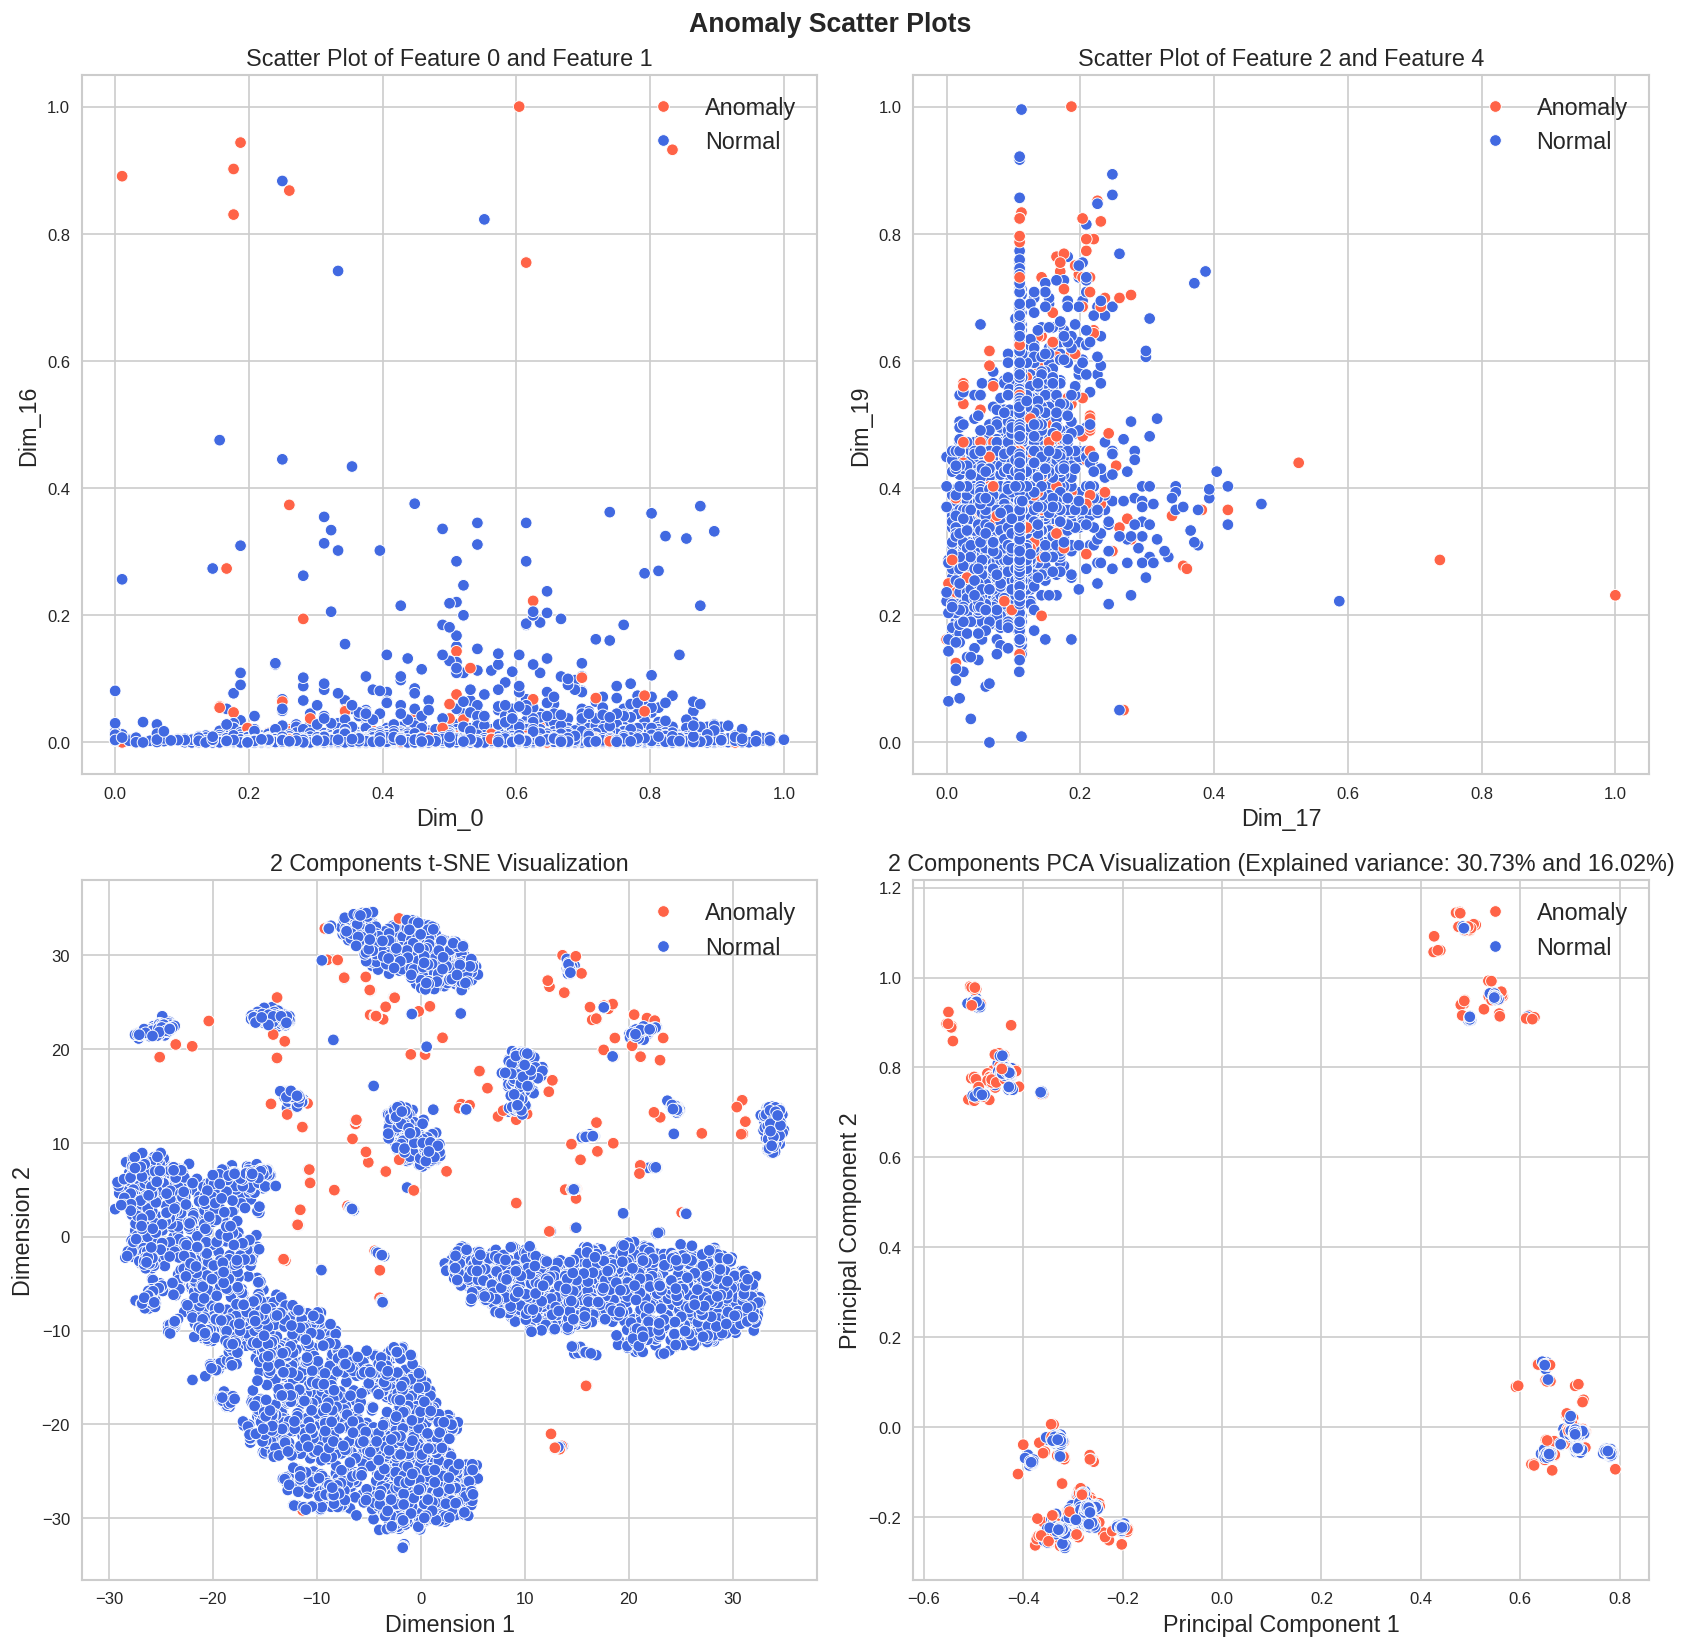

In [ ]:
# Plot anomaly scatter plots

AnomalyScatterplots(df, anomalies)

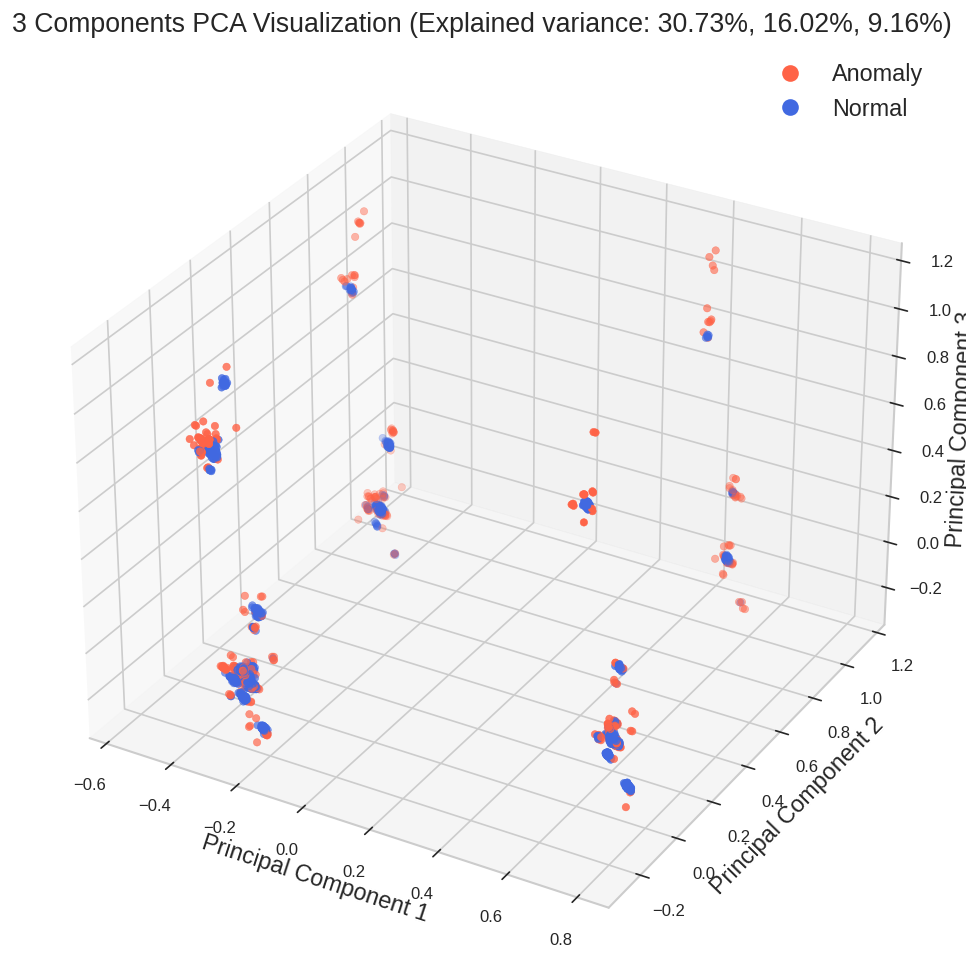

In [ ]:
# 3-components PCA

PCA3dscatter(df, anomalies)
#PCA3dscatterITERATIVE(df, anomalies)

### *__Coherence__*

In [ ]:
# Coherence metric

anomaly_labels = [anomalies_KNN, anomalies_LOF, anomalies_DBSCAN, anomalies_PCA, anomalies_SVM, majority_vote]
label_names = ['KNN', 'LOF', 'DBSCAN', 'PCA', 'SVM' ,"MV"]

# Iterate through each pair of label vectors
for i in range(len(anomaly_labels)):
    for j in range(i + 1, len(anomaly_labels)):
        labels_1 = anomaly_labels[i]
        labels_2 = anomaly_labels[j]

        print(f"Comparing {label_names[i]} with {label_names[j]}:")
        print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(labels_1, labels_2):.3f}")
        print()

Comparing KNN with LOF:
Adjusted Rand Index: 0.219

Comparing KNN with DBSCAN:
Adjusted Rand Index: 0.655

Comparing KNN with PCA:
Adjusted Rand Index: 0.374

Comparing KNN with SVM:
Adjusted Rand Index: 0.702

Comparing KNN with MV:
Adjusted Rand Index: 0.780

Comparing LOF with DBSCAN:
Adjusted Rand Index: 0.294

Comparing LOF with PCA:
Adjusted Rand Index: 0.455

Comparing LOF with SVM:
Adjusted Rand Index: 0.268

Comparing LOF with MV:
Adjusted Rand Index: 0.423

Comparing DBSCAN with PCA:
Adjusted Rand Index: 0.498

Comparing DBSCAN with SVM:
Adjusted Rand Index: 0.587

Comparing DBSCAN with MV:
Adjusted Rand Index: 0.729

Comparing PCA with SVM:
Adjusted Rand Index: 0.390

Comparing PCA with MV:
Adjusted Rand Index: 0.513

Comparing SVM with MV:
Adjusted Rand Index: 0.788



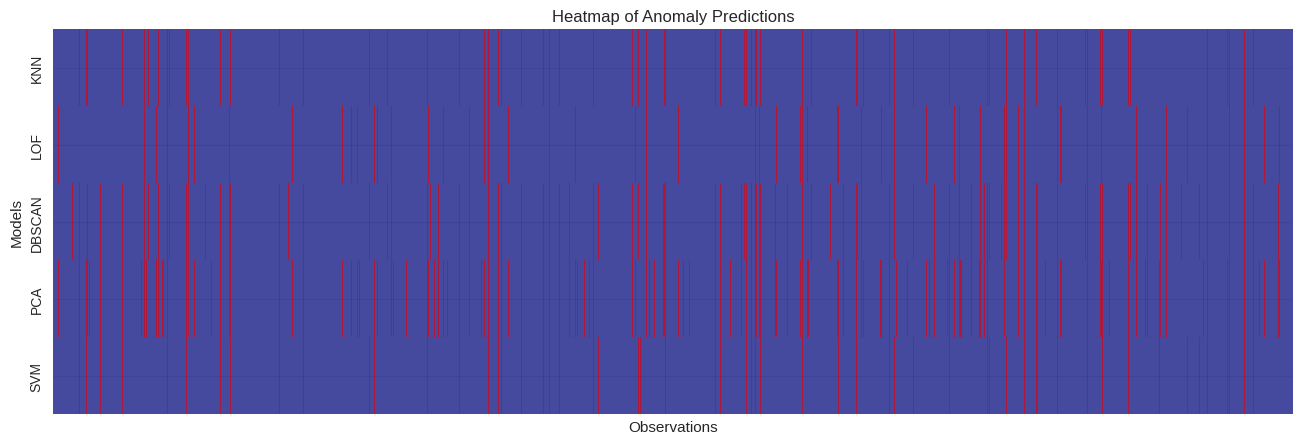

In [ ]:
# Heatmap that shows coherence between algorithms

plt.figure(figsize=(16, 5))
sns.heatmap(methods, cmap='RdYlBu', cbar=False, xticklabels=False, yticklabels=['KNN', 'LOF', 'DBSCAN', 'PCA', 'SVM'], alpha=0.9)
plt.title('Heatmap of Anomaly Predictions')
plt.xlabel('Observations')
plt.ylabel('Models')
plt.show()

## Convert to probabilities

> The final task involves estimating the probability of each data object being an anomaly. A logistic regression model is trained on the data using anomaly labels extracted from the majority vote model. Once the relationship is learned, the model uses `predict_proba` to generate probabilities for each data point.

In [ ]:
# Let's use the labels obtained with the best model
df["Label"] = majority_vote

print(f"N° of anomalies: {list(df['Label'].value_counts())[1]}")

X = df.drop(columns=['Label'])
y = df['Label']

model = LogisticRegression()           # defining and fitting the logistic model
model.fit(X, y)

probabilities = model.predict_proba(X)[:, 0]             # getting probabilities

df["Probability of being anomalous (percentage)"] = np.round(probabilities*100, 2)
#df.to_csv("AnomalyDf.csv")

N° of anomalies: 425


In [ ]:
df.sample(5)

Dim_0    Dim_16    Dim_17    Dim_18    Dim_19    Dim_20  Dim_1=0  \
6969  0.614583  0.010377  0.109192  0.172241  0.296296  0.200000    False   
2278  0.750000  0.000057  0.091922  0.209030  0.333333  0.220312     True   
2277  0.437500  0.007358  0.080780  0.093645  0.189815  0.151563    False   
2909  0.479167  0.002264  0.113092  0.214047  0.379630  0.201563     True   
7019  0.822917  0.002264  0.109192  0.091973  0.282407  0.110938    False   

      Dim_2=0  Dim_3=0  Dim_4=0  ...  Dim_8=0  Dim_9=0  Dim_10=0  Dim_11=0  \
6969    False     True     True  ...    False     True      True      True   
2278    False     True     True  ...     True    False      True      True   
2277     True     True     True  ...     True     True      True      True   
2909     True     True     True  ...     True     True     False      True   
7019     True     True     True  ...     True     True      True      True   

      Dim_12=0  Dim_13=0  Dim_14=0  Dim_15=0  Label  \
6969      True      True      True      True     -1   
2278      True      True      True      True      1   
2277      True      True      True     False      1   
2909      True      True      True      True      1   
7019      True      True      True      True      1   

      Probability of being anomalous (percentage)  
6969                                        76.53  
2278                                        10.18  
2277                                         2.81  
2909                                         2.08  
7019                                         0.29  

[5 rows x 23 columns]